# **Data Preparation Script**

**Goal:**  
Create one continuous, integrity-checked dataset that combines **daily**, **hourly**, and **minute** market data for any ticker (default = QQQ).

---

**Step 1 — Data Collection**  
- Pulls **1-minute** data for the **last 5 trading days** (max Yahoo limit = 7 days).  
- Pulls **1-hour** data for the **2 years before** the minute window.  
- Pulls **1-day** data for the **entire historical period** (since 1999) until the start of the hourly data.  
- Each segment is **cleaned**, **timezone-adjusted**, and **restricted to regular trading hours** (9:30–16:00 ET).  

---

**Step 2 — Dynamic Splicing & Validation**  
- Concatenates the three segments in **chronological order** (daily → hourly → minute).  
- Assigns a `frequency` label to each row (`daily`, `hourly`, or `minute`).  
- Automatically ensures **no overlap** between segments.  
- Runs **data integrity checks**, including:
  - Expected vs. actual rows per session  
  - Missing or duplicate timestamps  
  - Monotonic time order  
  - Session counts and gap detection  

---

**Step 3 — Return Calculations**  
- Computes both **simple percentage returns** and **log returns** separately within each frequency.  
- Ensures no “bleed” across frequencies (e.g., no daily-to-hourly drift).  

---

**Step 4 — Output**  
- Produces one unified DataFrame `combined_df` containing:

    price | high | low | open | volume | frequency | return | log_return


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time

TZ = "America/New_York"

# ---------- Helpers ----------

def _clean(df):
    if df is None or df.empty:
        return None
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    df = df.rename(columns={"Close": "price"})
    # yfinance intraday comes UTC; daily is tz-naive. Make everything ET.
    if df.index.tz is None:
        df.index = pd.to_datetime(df.index).tz_localize(TZ)  # treat daily as ET end-of-day
    else:
        df.index = df.index.tz_convert(TZ)
    return df.dropna()

def _rth_only(df):
    # Regular Trading Hours 09:30–16:00 ET
    return df.between_time("09:30", "16:00")

def _print_section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

# ---------- 1) Last 5 trading sessions of 1-minute ----------

def fetch_minutes_last_5_sessions(ticker="QQQ", rth_only=True):
    m = yf.download(ticker, period="7d", interval="1m", auto_adjust=True, progress=False)
    m = _clean(m)
    if m is None or m.empty:
        raise RuntimeError("No minute data returned.")
    if rth_only:
        m = _rth_only(m)

    m["session_date"] = m.index.date
    last_5 = sorted(m["session_date"].unique())[-5:]
    m5 = m[m["session_date"].isin(last_5)].copy()

    # sanity
    counts = m5.groupby("session_date").size()
    expected = len(last_5) * 390  # 6.5h * 60
    _print_section("Minute integrity")
    print(f"Sessions: {len(last_5)} -> {last_5}")
    print(f"Rows expected (~390/session): {expected}, actual: {len(m5)}")
    print("Per-session rows:\n", counts.tail())
    m5.drop(columns=["session_date"], inplace=True)
    return m5, last_5

# ---------- 2) ~2 years of 60-minute BEFORE minute window ----------

def fetch_hourly_before_minutes(ticker, minute_df, rth_only=True, days=729):
    # cutoff = first minute session open (09:30 ET) to ensure no overlap
    first_minute_day = minute_df.index.min().date()
    cutoff = pd.Timestamp(first_minute_day, tz=TZ) + pd.Timedelta(hours=9, minutes=30)

    h = yf.download(ticker, period=f"{int(days)}d", interval="60m", auto_adjust=True, progress=False)
    h = _clean(h)
    if h is None or h.empty:
        raise RuntimeError("No hourly data returned.")
    if rth_only:
        h = _rth_only(h)

    # strict no-overlap
    h = h[h.index < cutoff]

    # sanity
    h["session_date"] = h.index.date
    sessions = h["session_date"].nunique()
    per_sess = h.groupby("session_date").size()
    _print_section("Hourly integrity")
    print(f"Hourly date range: {h.index.min()} → {h.index.max()}")
    print(f"No overlap? hourly max < minute min  → {h.index.max() < minute_df.index.min()}")
    print(f"Approx sessions: {sessions} | rows: {len(h)} | ~7 bars/session expected")
    print("Tail per-session counts:\n", per_sess.tail())
    h.drop(columns=["session_date"], inplace=True)
    return h

# ---------- 3) Full-history daily up to the start of hourly/minute ----------

def fetch_daily_until_cutoff(ticker, hourly_df, minute_df):
    # cutoff = earliest timestamp across hourly & minute layer
    cutoff = min(hourly_df.index.min(), minute_df.index.min())
    # we fetch extra buffer and then slice to < cutoff (keeps performance fine)
    d = yf.download(ticker, period="max", interval="1d", auto_adjust=True, progress=False)
    d = _clean(d)
    if d is None or d.empty:
        raise RuntimeError("No daily data returned.")
    d = d[d.index < cutoff]

    # integrity: check for suspicious gaps (ignore weekends/holidays heuristically)
    di = d.index.tz_convert(TZ).normalize()
    diffs = (di[1:] - di[:-1]).days.values
    gaps = pd.Series(diffs, index=di[1:])
    # Flag suspicious gaps > 3 days (weekends ~2 days). Holidays may still appear; this is a conservative alert.
    suspicious = gaps[gaps > 3]

    _print_section("Daily integrity")
    print(f"Daily date range: {d.index.min().date()} → {d.index.max().date()}  | rows: {len(d)}")
    print("Monotonic increasing index?", d.index.is_monotonic_increasing)
    print("Duplicate timestamps?", d.index.duplicated().any())
    if len(suspicious):
        print("\n⚠️ Large gaps (>3 days) detected (likely holidays/halts/missing):")
        print(suspicious.head(20))
    else:
        print("\nNo suspicious (>3 day) gaps detected in daily series.")

    return d

# ---------- 4) Assemble & tag (no rolling features yet; this is ingestion/integrity) ----------

def build_three_layer(ticker="QQQ"):
    minute_df, last_5_sessions = fetch_minutes_last_5_sessions(ticker)
    hourly_df = fetch_hourly_before_minutes(ticker, minute_df)
    daily_df  = fetch_daily_until_cutoff(ticker, hourly_df, minute_df)

    minute_df["frequency"] = "minute"
    hourly_df["frequency"] = "hourly"
    daily_df["frequency"]  = "daily"

    # Per-frequency returns (no bleed)
    def add_returns(df):
        out = df.copy()
        out["return"] = out["price"].pct_change()
        out["log_return"] = np.log(out["price"]).diff()
        return out

    minute_df = add_returns(minute_df)
    hourly_df = add_returns(hourly_df)
    daily_df  = add_returns(daily_df)

    # Final concatenated view (if you want one frame)
    combined = pd.concat([daily_df, hourly_df, minute_df]).sort_index()
    _print_section("Combined summary")
    print("Frequencies:", combined["frequency"].value_counts().to_dict())
    print("Date range:", combined.index.min(), "→", combined.index.max())
    print("No hourly/minute overlap? ", hourly_df.index.max() < minute_df.index.min())
    print("No daily/hourly overlap?  ", daily_df.index.max()  < hourly_df.index.min())

    return {"daily": daily_df, "hourly": hourly_df, "minute": minute_df, "combined": combined}

# ---------- Run ----------

layers = build_three_layer("QQQ")

# Quick head/tail checks (optional):
for k, v in layers.items():
    if k == "combined":
        continue
    _print_section(f"{k.capitalize()} head/tail")
    print(v[["price","frequency"]].head(3))
    print(v[["price","frequency"]].tail(3))



Minute integrity
Sessions: 5 -> [datetime.date(2025, 12, 2), datetime.date(2025, 12, 3), datetime.date(2025, 12, 4), datetime.date(2025, 12, 5), datetime.date(2025, 12, 8)]
Rows expected (~390/session): 1950, actual: 1613
Per-session rows:
 session_date
2025-12-02    390
2025-12-03    390
2025-12-04    390
2025-12-05    390
2025-12-08     53
dtype: int64

Hourly integrity
Hourly date range: 2023-01-12 09:30:00-05:00 → 2025-12-01 15:30:00-05:00
No overlap? hourly max < minute min  → True
Approx sessions: 724 | rows: 5040 | ~7 bars/session expected
Tail per-session counts:
 session_date
2025-11-24    7
2025-11-25    7
2025-11-26    7
2025-11-28    3
2025-12-01    7
dtype: int64

Daily integrity
Daily date range: 1999-03-10 → 2023-01-12  | rows: 6002
Monotonic increasing index? True
Duplicate timestamps? False

⚠️ Large gaps (>3 days) detected (likely holidays/halts/missing):
Date
1999-06-01 00:00:00-04:00    4
1999-07-06 00:00:00-04:00    4
1999-09-07 00:00:00-04:00    4
1999-12-27 00:0

In [2]:
daily_df = layers["daily"]
hourly_df = layers["hourly"]
minute_df = layers["minute"]
combined_df = layers["combined"]

In [3]:
daily_df

Price,price,High,Low,Open,Volume,frequency,return,log_return
Date,,,,,,,,
1999-03-10 00:00:00-05:00,43.184216,43.263501,42.523502,43.237073,5232000,daily,NaN,NaN
1999-03-11 00:00:00-05:00,43.395634,43.752419,42.549921,43.501348,9688600,daily,0.004896,0.004884
1999-03-12 00:00:00-05:00,42.338497,43.263496,41.994926,43.237067,8743600,daily,-0.024360,-0.024662
1999-03-15 00:00:00-05:00,43.554222,43.607079,42.206367,42.655652,6369000,daily,0.028714,0.028310
1999-03-16 00:00:00-05:00,43.924213,44.109213,43.263500,43.739214,4905800,daily,0.008495,0.008459
...,...,...,...,...,...,...,...,...
2023-01-06 00:00:00-05:00,264.379547,265.500814,256.058681,259.019191,54659700,daily,0.027601,0.027227
2023-01-09 00:00:00-05:00,266.090973,270.762859,265.481174,266.376182,45568700,daily,0.006473,0.006453
2023-01-10 00:00:00-05:00,268.343292,268.451499,264.546784,265.058222,35247800,daily,0.008464,0.008429


In [4]:
hourly_df

Price,price,High,Low,Open,Volume,frequency,return,log_return
Datetime,,,,,,,,
2023-01-12 09:30:00-05:00,277.470001,278.760010,273.739990,278.119995,22879832,hourly,NaN,NaN
2023-01-12 10:30:00-05:00,277.100006,278.369995,275.619995,277.470001,7382983,hourly,-0.001333,-0.001334
2023-01-12 11:30:00-05:00,279.265015,279.339996,276.309906,277.109985,6691650,hourly,0.007813,0.007783
2023-01-12 12:30:00-05:00,277.829987,279.750000,277.630005,279.260010,4898294,hourly,-0.005139,-0.005152
2023-01-12 13:30:00-05:00,279.119995,280.100006,277.140015,277.799988,6015363,hourly,0.004643,0.004632
...,...,...,...,...,...,...,...,...
2025-12-01 11:30:00-05:00,618.423279,618.750000,616.659973,616.679993,2339406,hourly,0.002827,0.002823
2025-12-01 12:30:00-05:00,618.649902,619.440125,618.130005,618.419983,1758817,hourly,0.000366,0.000366
2025-12-01 13:30:00-05:00,617.020020,619.359985,616.919800,618.690002,2207952,hourly,-0.002635,-0.002638


In [5]:
minute_df

Price,price,High,Low,Open,Volume,frequency,return,log_return
Datetime,,,,,,,,
2025-12-02 09:30:00-05:00,619.090027,619.659973,619.015015,619.460022,709215,minute,NaN,NaN
2025-12-02 09:31:00-05:00,619.500000,619.550110,618.979980,619.039978,213396,minute,0.000662,0.000662
2025-12-02 09:32:00-05:00,619.559998,619.849976,619.289978,619.530029,203539,minute,0.000097,0.000097
2025-12-02 09:33:00-05:00,619.979980,620.299988,619.559998,619.559998,200669,minute,0.000678,0.000678
2025-12-02 09:34:00-05:00,620.278015,620.278015,619.753784,619.989990,137942,minute,0.000481,0.000481
...,...,...,...,...,...,...,...,...
2025-12-08 10:18:00-05:00,625.809998,626.096802,625.780029,626.039978,56043,minute,-0.000423,-0.000423
2025-12-08 10:19:00-05:00,625.729980,625.949890,625.679993,625.799988,65497,minute,-0.000128,-0.000128
2025-12-08 10:20:00-05:00,625.679993,625.830017,625.419983,625.739990,73105,minute,-0.000080,-0.000080


In [6]:
combined_df

Price,price,High,Low,Open,Volume,frequency,return,log_return
1999-03-10 00:00:00-05:00,43.184216,43.263501,42.523502,43.237073,5232000,daily,NaN,NaN
1999-03-11 00:00:00-05:00,43.395634,43.752419,42.549921,43.501348,9688600,daily,0.004896,0.004884
1999-03-12 00:00:00-05:00,42.338497,43.263496,41.994926,43.237067,8743600,daily,-0.024360,-0.024662
1999-03-15 00:00:00-05:00,43.554222,43.607079,42.206367,42.655652,6369000,daily,0.028714,0.028310
1999-03-16 00:00:00-05:00,43.924213,44.109213,43.263500,43.739214,4905800,daily,0.008495,0.008459
...,...,...,...,...,...,...,...,...
2025-12-08 10:18:00-05:00,625.809998,626.096802,625.780029,626.039978,56043,minute,-0.000423,-0.000423
2025-12-08 10:19:00-05:00,625.729980,625.949890,625.679993,625.799988,65497,minute,-0.000128,-0.000128
2025-12-08 10:20:00-05:00,625.679993,625.830017,625.419983,625.739990,73105,minute,-0.000080,-0.000080
2025-12-08 10:21:00-05:00,625.519897,625.789978,625.434998,625.700012,93066,minute,-0.000256,-0.000256


In [7]:
import pandas as pd
import plotly.graph_objects as go

df = combined_df.sort_index()

# --- Find the first timestamp of hourly and minute segments ---
try:
    ts_hourly = df.index[df["frequency"].eq("hourly")][0]
except IndexError:
    ts_hourly = None

try:
    ts_minute = df.index[df["frequency"].eq("minute")][0]
except IndexError:
    ts_minute = None

def to_py_naive(ts):
    """Return a timezone-naive Python datetime from a pandas-like timestamp."""
    if ts is None:
        return None
    t = pd.Timestamp(ts)
    # If tz-aware, strip timezone; otherwise leave as-is
    try:
        if t.tzinfo is not None:
            t = t.tz_convert(None)
    except Exception:
        # If tz_convert fails (naive), ignore
        pass
    return t.to_pydatetime()

x_hourly  = to_py_naive(ts_hourly)
x_minute  = to_py_naive(ts_minute)

# --- Build Plotly figure with all points ---
fig = go.Figure()
fig.add_trace(go.Scattergl(
    x=df.index, y=df["price"],
    mode="lines", name="QQQ Price", line=dict(width=1)
))

# --- Add two vertical lines as shapes (robust with datetimes) ---
if x_hourly is not None:
    fig.add_shape(
        type="line", x0=x_hourly, x1=x_hourly, y0=0, y1=1,
        xref="x", yref="paper",
        line=dict(width=2, dash="dot")
    )
    fig.add_annotation(x=x_hourly, y=1, yref="paper", text="Start of hourly",
                       showarrow=False, xanchor="left")

if x_minute is not None:
    fig.add_shape(
        type="line", x0=x_minute, x1=x_minute, y0=0, y1=1,
        xref="x", yref="paper",
        line=dict(width=2, dash="dot")
    )
    fig.add_annotation(x=x_minute, y=1, yref="paper", text="Start of minute",
                       showarrow=False, xanchor="left")

fig.update_layout(
    title=f"QQQ — All Points with Daily→Hourly and Hourly→Minute Transitions<br>{df.index.min().date()} → {df.index.max().date()}",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


# **FEATURE ENGINEERING SCRIPT**
We built three separate anchored feature sets from `combined_df`, each derived at multiple time resolutions (`minute`, `hourly`, `daily`) using the same anchor framework (`is_day_close`, `is_hour_close`, `is_daily_anchor`):

1. **Rolling Returns (`df_rr_all`)**  
   - Computes trailing percentage change `(P_t / P_{t-k} - 1)` using anchor-based windows.  
   - Values update only at anchor timestamps and forward-fill between anchors.  
   - Represents momentum and directionality of price movement.

2. **Volume Features (`df_vol`)**  
   - Uses `rolling_volume_roc_*` features to capture relative change in trading activity.  
   - Measures participation and liquidity intensity; higher values indicate spikes in market activity.  
   - Sum variants were generated but omitted for modeling since ROC aligns with return-style scaling.

3. **Volatility Features (`df_volatility`)**  
   - Computes realized variability of returns across anchor windows.  
   - Includes both `stdev` (dispersion around mean) and `realized` (total movement magnitude).  
   - Captures market uncertainty and amplitude of price movement at multiple horizons.

Each DataFrame uses identical indexing and anchor definitions, allowing them to merge seamlessly for unified modeling and feature analysis.


In [8]:
# ---------- DATA PREP: anchor markers ----------
def add_anchor_markers(df: pd.DataFrame, *, freq_col: str = "frequency") -> pd.DataFrame:
    """
    Adds:
      - is_daily_anchor: True on all daily rows.
      - is_day_close: True on the last intraday row of each calendar date (hourly/minute).
      - is_hour_close: True on the last minute row of each (date, hour) (only on minute freq).
    """
    out = df.copy().sort_index()
    assert isinstance(out.index, pd.DatetimeIndex), "Index must be a DatetimeIndex"
    assert "price" in out.columns and freq_col in out.columns

    # normalize date for grouping boundaries
    ddate = out.index.normalize()
    out["__ddate"] = ddate

    # daily anchor = any daily row
    out["is_daily_anchor"] = (out[freq_col] == "daily")

    # day_close among intraday: last row per calendar date within intraday
    intraday_mask = out[freq_col].isin(["hourly", "minute"])
    out["is_day_close"] = False
    if intraday_mask.any():
        intraday = out.loc[intraday_mask]
        last_rows = intraday.groupby("__ddate").tail(1).index
        out.loc[last_rows, "is_day_close"] = True

    # hour_close among minute rows: last minute in each (date, hour)
    out["is_hour_close"] = False
    minute_mask = (out[freq_col] == "minute")
    if minute_mask.any():
        # group by date + hour on minute rows only
        key = pd.MultiIndex.from_arrays(
            [out.loc[minute_mask, "__ddate"], out.loc[minute_mask].index.hour],
            names=["date", "hour"]
        )
        grp = out.loc[minute_mask].groupby(key, sort=False)
        hour_last_idx = grp.tail(1).index
        out.loc[hour_last_idx, "is_hour_close"] = True

    # housekeeping
    out.drop(columns=["__ddate"], inplace=True)
    return out

In [9]:
# ---------- ROLLING RETURNS CALCULATION FUNCTION ----------

def add_rolling_return_via_anchors(
    df: pd.DataFrame,
    *,
    source_freq: str = "daily",  # "daily" (uses daily + day_close anchors) or "hourly" (uses hourly closes in minute data)
    window: int = 5,
    freq_col: str = "frequency",
    colname: str | None = None
) -> pd.DataFrame:
    """
    Compute trailing return (P_t / P_{t-k} - 1) at anchor timestamps, then
    forward-fill that value to rows until the next anchor. Anchors:
      - source_freq == "daily": union of daily rows + intraday day_close rows.
      - source_freq == "hourly": hourly rows as anchors; plus in minute data use is_hour_close.
      - source_freq == "minute": every minute row is an anchor (standard rolling on minute).
    """
    out = df.copy().sort_index()
    name = colname or f"rolling_return_{window}@{source_freq}"
    if name in out.columns:
        out.drop(columns=[name], inplace=True)
    out[name] = np.nan

    # Build the anchor index set
    if source_freq == "daily":
        # Use *actual* daily rows where they exist, and for periods without daily rows,
        # fall back to intraday day closes.
        daily_idx = out.index[out[freq_col] == "daily"]
        day_close_idx = out.index[out.get("is_day_close", False)]
        anchors = daily_idx.union(day_close_idx)
    elif source_freq == "hourly":
        # Hourly rows are anchors. If you only have minute data later, use minute hour_closes.
        hourly_idx = out.index[out[freq_col] == "hourly"]
        hour_close_idx = out.index[out.get("is_hour_close", False)]
        anchors = hourly_idx.union(hour_close_idx)
    elif source_freq == "minute":
        anchors = out.index[out[freq_col] == "minute"]
    else:
        raise ValueError("source_freq must be one of: 'daily', 'hourly', 'minute'")

    anchors = anchors.sort_values()
    if len(anchors) == 0:
        return out  # nothing to do

    # Loop across anchors, compute return using previous anchors, and propagate to the next anchor
    for i, ts in enumerate(anchors):
        if i >= window:
            past_ts = anchors[i - window]
            p_now = float(out.at[ts, "price"])
            p_then = float(out.at[past_ts, "price"])
            val = (p_now / p_then) - 1.0
        else:
            val = np.nan

        # assign at the anchor timestamp itself
        out.at[ts, name] = val

        # fill forward strictly between this and next anchor
        if i < len(anchors) - 1:
            next_ts = anchors[i + 1]
            seg_idx = out.index[(out.index > ts) & (out.index < next_ts)]
        else:
            seg_idx = out.index[out.index > ts]

        if len(seg_idx):
            out.loc[seg_idx, name] = val

    return out


In [10]:
# --- Configure windows per frequency (bars) ---
windows_by_freq = {
    "minute": [1, 5, 15, 30],                 # T1
    "hourly": [1, 3],                         # T2
    "daily":  [1, 5, 21, 63, 126, 252],       # T3  (≈ 1d, 1w, 1m, 3m, 6m, 1y)
}

# Start from anchor-marked DF
df_anchors = add_anchor_markers(combined_df.copy())

# Build all rolling-return columns
df_rr_all = df_anchors.copy()
for freq, wins in windows_by_freq.items():
    for w in wins:
        df_rr_all = add_rolling_return_via_anchors(
            df_rr_all,
            source_freq=freq,
            window=w,
            freq_col="frequency",
            colname=f"rolling_return_{w}@{freq}"
        )

# ---- Quick integrity checks ----
# 1) Show created columns
created_cols = [c for c in df_rr_all.columns if c.startswith("rolling_return_")]
print(f"Created {len(created_cols)} rolling-return columns:")
print(sorted(created_cols))

# 2) Non-null counts by frequency for each column
freqs = ["daily", "hourly", "minute"]
rows = []
for col in created_cols:
    for f in freqs:
        nn = df_rr_all.loc[df_rr_all["frequency"]==f, col].notna().sum()
        rows.append((col, f, nn))
check_df = pd.DataFrame(rows, columns=["feature","frequency","non_null_count"]).sort_values(["feature","frequency"])
print(check_df.head(30))

# 3) Spot samples
for f in freqs:
    cols_to_show = ["price", "frequency"] + [c for c in created_cols if c.endswith(f"@{f}")][:3]  # show up to 3 per freq
    print(f"\n--- {f.upper()} sample ---")
    print(df_rr_all.loc[df_rr_all["frequency"]==f, cols_to_show].head(12))
    print(df_rr_all.loc[df_rr_all["frequency"]==f, cols_to_show].tail(12))


Created 12 rolling-return columns:
['rolling_return_126@daily', 'rolling_return_15@minute', 'rolling_return_1@daily', 'rolling_return_1@hourly', 'rolling_return_1@minute', 'rolling_return_21@daily', 'rolling_return_252@daily', 'rolling_return_30@minute', 'rolling_return_3@hourly', 'rolling_return_5@daily', 'rolling_return_5@minute', 'rolling_return_63@daily']
                     feature frequency  non_null_count
30  rolling_return_126@daily     daily            5876
31  rolling_return_126@daily    hourly            5040
32  rolling_return_126@daily    minute            1613
6   rolling_return_15@minute     daily               0
7   rolling_return_15@minute    hourly               0
8   rolling_return_15@minute    minute            1598
18    rolling_return_1@daily     daily            6001
19    rolling_return_1@daily    hourly            5040
20    rolling_return_1@daily    minute            1613
12   rolling_return_1@hourly     daily               0
13   rolling_return_1@hourly    h

In [11]:
df_rr_all.columns

Index(['price', 'High', 'Low', 'Open', 'Volume', 'frequency', 'return',
       'log_return', 'is_daily_anchor', 'is_day_close', 'is_hour_close',
       'rolling_return_1@minute', 'rolling_return_5@minute',
       'rolling_return_15@minute', 'rolling_return_30@minute',
       'rolling_return_1@hourly', 'rolling_return_3@hourly',
       'rolling_return_1@daily', 'rolling_return_5@daily',
       'rolling_return_21@daily', 'rolling_return_63@daily',
       'rolling_return_126@daily', 'rolling_return_252@daily'],
      dtype='object', name='Price')

In [12]:
#=======================================================
#==================      TESTS      ====================
#=======================================================

# 1) Each rolling_return_X@daily only changes on daily rows or day_close anchors
for col in [c for c in df_rr_all.columns if c.endswith('@daily')]:
    s = df_rr_all[col]
    # points where value changes
    change_idx = s[(s!=s.shift(1)) & s.notna()].index
    # should coincide with anchors (daily rows or is_day_close)
    anchors = df_rr_all.index[(df_rr_all['frequency']=='daily') | (df_rr_all.get('is_day_close', False))]
    assert change_idx.difference(anchors).empty, f"Non-anchor change in {col}"

# 2) Same idea for @hourly: changes only on hourly rows or is_hour_close in minutes
for col in [c for c in df_rr_all.columns if c.endswith('@hourly')]:
    s = df_rr_all[col]
    change_idx = s[(s!=s.shift(1)) & s.notna()].index
    anchors = df_rr_all.index[(df_rr_all['frequency']=='hourly') | (df_rr_all.get('is_hour_close', False))]
    assert change_idx.difference(anchors).empty, f"Non-anchor change in {col}"

# 3) Warm-up sanity: the count of NaNs at anchors should be ≈ window for each series (minus any early missing)
def warmup_nans(col, freq_tag):
    s = df_rr_all[col]
    if freq_tag == 'daily':
        anchors = df_rr_all.index[(df_rr_all['frequency']=='daily') | (df_rr_all.get('is_day_close', False))]
    elif freq_tag == 'hourly':
        anchors = df_rr_all.index[(df_rr_all['frequency']=='hourly') | (df_rr_all.get('is_hour_close', False))]
    else:
        anchors = df_rr_all.index[df_rr_all['frequency']=='minute']
    return s.loc[anchors].isna().sum()

for col in [c for c in df_rr_all.columns if c.startswith('rolling_return_')]:
    w = int(col.split('_')[2].split('@')[0])
    tag = col.split('@')[1]
    print(col, "anchor-NaNs:", warmup_nans(col, tag), "expected≈", w)


rolling_return_1@minute anchor-NaNs: 1 expected≈ 1
rolling_return_5@minute anchor-NaNs: 5 expected≈ 5
rolling_return_15@minute anchor-NaNs: 15 expected≈ 15
rolling_return_30@minute anchor-NaNs: 30 expected≈ 30
rolling_return_1@hourly anchor-NaNs: 1 expected≈ 1
rolling_return_3@hourly anchor-NaNs: 3 expected≈ 3
rolling_return_1@daily anchor-NaNs: 1 expected≈ 1
rolling_return_5@daily anchor-NaNs: 5 expected≈ 5
rolling_return_21@daily anchor-NaNs: 21 expected≈ 21
rolling_return_63@daily anchor-NaNs: 63 expected≈ 63
rolling_return_126@daily anchor-NaNs: 126 expected≈ 126
rolling_return_252@daily anchor-NaNs: 252 expected≈ 252


In [13]:
#=======================================================
#==================      TESTS      ====================
#=======================================================

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

# Load file
df = df_rr_all

# Try to set datetime index
if "Price" in df.columns:
    df["Price"] = pd.to_datetime(df["Price"], errors="coerce")
    df = df.set_index("Price")

# --- 1) INTEGRITY VERIFICATION ---
rr_cols = [c for c in df.columns if c.startswith("rolling_return_")]
freq_changes = df["frequency"].ne(df["frequency"].shift()).sum()

integrity_issues = []
freq_change_indices = df.index[df["frequency"].ne(df["frequency"].shift())]

for col in rr_cols:
    for ts in freq_change_indices:
        prev_val = df[col].shift(1).loc[ts]
        if isinstance(prev_val, pd.Series):
            prev_val = prev_val.iloc[0]
        curr_val = df[col].loc[ts]
        if isinstance(curr_val, pd.Series):
            curr_val = curr_val.iloc[0]
        if pd.notna(prev_val) and pd.notna(curr_val) and abs(curr_val - prev_val) < 1e-9:
            integrity_issues.append((ts, col, curr_val))

integrity_summary = {
    "total_freq_changes": freq_changes,
    "columns_checked": len(rr_cols),
    "potential_cross_freq_leaks": len(integrity_issues),
}

# --- 4) STATISTICAL SANITY CHECKS ---
extra_stats = []
for col in rr_cols:
    x = df[col].dropna()
    if len(x) > 1:
        extra_stats.append({
            "feature": col,
            "mean": x.mean(),
            "std": x.std(),
            "skew": skew(x),
            "kurtosis": kurtosis(x),
            "min": x.min(),
            "max": x.max(),
        })

extra_stats_df = pd.DataFrame(extra_stats).sort_values("mean")

print("\nIntegrity Summary:\n", integrity_summary)
print("\nTop 10 Feature Stats:\n", extra_stats_df.head(10))



Integrity Summary:
 {'total_freq_changes': np.int64(3), 'columns_checked': 12, 'potential_cross_freq_leaks': 14}

Top 10 Feature Stats:
                     feature      mean       std      skew   kurtosis  \
0   rolling_return_1@minute  0.000007  0.000407  0.319620  24.776192   
1   rolling_return_5@minute  0.000030  0.000943  0.918835   8.637626   
2  rolling_return_15@minute  0.000074  0.001577  0.314281   3.103157   
3  rolling_return_30@minute  0.000146  0.002191 -0.110244   2.263914   
4   rolling_return_1@hourly  0.000257  0.004263  0.187710  16.083921   
5   rolling_return_3@hourly  0.000726  0.007301  0.326584  13.948262   
6    rolling_return_1@daily  0.000972  0.014530  0.276146   9.882888   
7    rolling_return_5@daily  0.006929  0.031126 -0.501956   3.549880   
8   rolling_return_21@daily  0.013384  0.059027 -0.390821   3.321723   
9   rolling_return_63@daily  0.053975  0.102384 -0.671090   3.197539   

        min       max  
0 -0.004582  0.004463  
1 -0.004790  0.006783

In [14]:
def add_volume_feature_via_anchors(
    df: pd.DataFrame,
    *,
    source_freq: str = "daily",   # 'daily' | 'hourly' | 'minute'
    window: int = 5,
    agg: str = "sum",             # 'sum' | 'roc'
    base_col: str = "volume",
    freq_col: str = "frequency",
    colname: str | None = None
) -> pd.DataFrame:
    """
    Anchored volume features with forward-fill between anchors.

    - agg='sum': rolling sum of the last `window` anchor volumes (inclusive).
      Warmup: needs window-1 prior anchors.
    - agg='roc': rate of change vs `window` anchors back: V_t / V_{t-k} - 1.
      Warmup: needs `window` prior anchors (handles zero-denominator as NaN).
    """
    if base_col not in df.columns:
        raise KeyError(f"'{base_col}' not found")
    if source_freq not in {"daily","hourly","minute"}:
        raise ValueError("source_freq must be 'daily'|'hourly'|'minute'")
    if agg not in {"sum","roc"}:
        raise ValueError("agg must be 'sum'|'roc'")

    out = df.copy().sort_index()

    # name
    if colname is None:
        name = f"rolling_volume_{'sum' if agg=='sum' else 'roc'}_{window}@{source_freq}"
    else:
        name = colname
    if name in out.columns:
        out.drop(columns=[name], inplace=True)
    out[name] = np.nan

    # anchors
    if source_freq == "daily":
        anchors = out.index[(out["is_daily_anchor"]) | (out["is_day_close"])]
    elif source_freq == "hourly":
        anchors = out.index[(out[freq_col] == "hourly") | (out["is_hour_close"])]
    else:  # 'minute'
        anchors = out.index[out[freq_col] == "minute"]
    anchors = anchors.sort_values()
    if len(anchors) == 0:
        return out

    v_anchor = out.loc[anchors, base_col].astype(float)

    for i, ts in enumerate(anchors):
        if agg == "sum":
            if i >= window - 1:
                window_slice = anchors[i - window + 1 : i + 1]
                val = float(out.loc[window_slice, base_col].sum())
            else:
                val = np.nan
        else:  # 'roc'
            if i >= window:
                past_ts = anchors[i - window]
                v_now = float(v_anchor.loc[ts])
                v_then = float(v_anchor.loc[past_ts])
                val = (v_now / v_then - 1.0) if v_then != 0.0 else np.nan
            else:
                val = np.nan

        out.at[ts, name] = val

        # forward-fill strictly until next anchor
        if i < len(anchors) - 1:
            next_ts = anchors[i + 1]
            seg_idx = out.index[(out.index > ts) & (out.index < next_ts)]
        else:
            seg_idx = out.index[out.index > ts]
        if len(seg_idx):
            out.loc[seg_idx, name] = val

    return out

In [15]:
windows_by_freq = {
    "minute": [1, 5, 15, 30],                 # T1
    "hourly": [1, 3],                         # T2
    "daily":  [1, 5, 21, 63, 126, 252],       # T3
}

# starting point: copy + add anchors
df_vol = add_anchor_markers(combined_df.copy())

# build all columns (sum + roc) per window/freq
for freq, wins in windows_by_freq.items():
    for w in wins:
        df_vol = add_volume_feature_via_anchors(
            df_vol, source_freq=freq, window=w, agg="sum",
            base_col="Volume", freq_col="frequency",
            colname=f"rolling_volume_sum_{w}@{freq}"
        )
        df_vol = add_volume_feature_via_anchors(
            df_vol, source_freq=freq, window=w, agg="roc",
            base_col="Volume", freq_col="frequency",
            colname=f"rolling_volume_roc_{w}@{freq}"
        )

In [16]:
df_vol

Price,price,High,Low,Open,Volume,frequency,return,log_return,is_daily_anchor,is_day_close,...,rolling_volume_sum_5@daily,rolling_volume_roc_5@daily,rolling_volume_sum_21@daily,rolling_volume_roc_21@daily,rolling_volume_sum_63@daily,rolling_volume_roc_63@daily,rolling_volume_sum_126@daily,rolling_volume_roc_126@daily,rolling_volume_sum_252@daily,rolling_volume_roc_252@daily
1999-03-10 00:00:00-05:00,43.184216,43.263501,42.523502,43.237073,5232000,daily,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-11 00:00:00-05:00,43.395634,43.752419,42.549921,43.501348,9688600,daily,0.004896,0.004884,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-12 00:00:00-05:00,42.338497,43.263496,41.994926,43.237067,8743600,daily,-0.024360,-0.024662,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-15 00:00:00-05:00,43.554222,43.607079,42.206367,42.655652,6369000,daily,0.028714,0.028310,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-16 00:00:00-05:00,43.924213,44.109213,43.263500,43.739214,4905800,daily,0.008495,0.008459,True,False,...,34939000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-08 10:18:00-05:00,625.809998,626.096802,625.780029,626.039978,56043,minute,-0.000423,-0.000423,False,False,...,19932645.0,-0.840874,87289790.0,-0.884913,337550561.0,-0.927931,685088814.0,-0.909744,1.362828e+09,-0.767235
2025-12-08 10:19:00-05:00,625.729980,625.949890,625.679993,625.799988,65497,minute,-0.000128,-0.000128,False,False,...,19932645.0,-0.840874,87289790.0,-0.884913,337550561.0,-0.927931,685088814.0,-0.909744,1.362828e+09,-0.767235
2025-12-08 10:20:00-05:00,625.679993,625.830017,625.419983,625.739990,73105,minute,-0.000080,-0.000080,False,False,...,19932645.0,-0.840874,87289790.0,-0.884913,337550561.0,-0.927931,685088814.0,-0.909744,1.362828e+09,-0.767235
2025-12-08 10:21:00-05:00,625.519897,625.789978,625.434998,625.700012,93066,minute,-0.000256,-0.000256,False,False,...,19932645.0,-0.840874,87289790.0,-0.884913,337550561.0,-0.927931,685088814.0,-0.909744,1.362828e+09,-0.767235


In [17]:
#=======================================================
#==================   VOLUME ROC TESTS   ===============
#=======================================================

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# --- Expect df_vol already defined in notebook ---
df = df_vol

# --- pick only ROC features (drop sums) ---
vol_cols = [c for c in df.columns if c.startswith("rolling_volume_roc_")]
print(f"Found {len(vol_cols)} ROC columns")

# --- helper: parse window & tag ---
def parse_window_and_tag(col: str):
    k = int(col.split('_')[3].split('@')[0])
    tag = col.split('@')[1]
    return k, tag

# --- anchor sets ---
anchors_daily  = df.index[(df.get('is_daily_anchor', False)) | (df.get('is_day_close', False))]
anchors_hourly = df.index[(df['frequency']=='hourly') | (df.get('is_hour_close', False))]
anchors_minute = df.index[df['frequency']=='minute']

#=======================================================
# 1) Changes only at valid anchors
#=======================================================
for col in [c for c in vol_cols if c.endswith('@daily')]:
    s = df[col]
    change_idx = s[(s != s.shift(1)) & s.notna()].index
    assert change_idx.difference(anchors_daily).empty, f"Non-anchor change in {col}"

for col in [c for c in vol_cols if c.endswith('@hourly')]:
    s = df[col]
    change_idx = s[(s != s.shift(1)) & s.notna()].index
    assert change_idx.difference(anchors_hourly).empty, f"Non-anchor change in {col}"

#=======================================================
# 2) Warm-up NaN count at anchors ≈ window
#=======================================================
def warmup_nans(col, tag):
    s = df[col]
    if tag == 'daily':
        anchors = anchors_daily
    elif tag == 'hourly':
        anchors = anchors_hourly
    else:
        anchors = anchors_minute
    return s.loc[anchors].isna().sum()

for col in vol_cols:
    k, tag = parse_window_and_tag(col)
    print(col, "anchor-NaNs:", warmup_nans(col, tag), "expected≈", k)

#=======================================================
# 3) Segment-by-segment propagation test
#=======================================================
def assert_segment_propagation(df, col, tag, atol=1e-12):
    s = df[col]
    if tag == "daily":
        anchors = anchors_daily
    elif tag == "hourly":
        anchors = anchors_hourly
    else:
        anchors = anchors_minute
    anchors = anchors.sort_values()

    for i in range(len(anchors)):
        a = anchors[i]
        val = s.loc[a]
        if i < len(anchors)-1:
            b = anchors[i+1]
            seg_idx = df.index[(df.index > a) & (df.index < b)]
        else:
            seg_idx = df.index[df.index > a]

        seg_vals = s.loc[seg_idx]
        if pd.isna(val):
            assert seg_vals.isna().all(), f"{col}: expected all-NaN in segment after {a}, found non-NaN."
        else:
            m = seg_vals.notna()
            if m.any():
                ok = np.allclose(seg_vals[m].values, val, rtol=0.0, atol=atol)
                assert ok, f"{col}: values changed within segment ({a} .. next)."

for col in vol_cols:
    _, tag = parse_window_and_tag(col)
    assert_segment_propagation(df, col, tag)
print("Segment propagation OK for all ROC columns.")

#=======================================================
# 4) Cross-frequency integrity (soft check)
#=======================================================
freq_changes = df["frequency"].ne(df["frequency"].shift()).sum()
freq_change_indices = df.index[df["frequency"].ne(df["frequency"].shift())]
integrity_issues = []

for col in vol_cols:
    s = df[col]
    for ts in freq_change_indices:
        prev_val = s.shift(1).loc[ts]
        curr_val = s.loc[ts]
        if pd.notna(prev_val) and pd.notna(curr_val) and abs(curr_val - prev_val) < 1e-12:
            integrity_issues.append((ts, col, curr_val))

integrity_summary = {
    "total_freq_changes": int(freq_changes),
    "columns_checked": len(vol_cols),
    "potential_cross_freq_leaks": len(integrity_issues),
}
print("\nIntegrity Summary:\n", integrity_summary)

#=======================================================
# 5) Statistical sanity (summary)
#=======================================================
extra_stats = []
for col in vol_cols:
    x = df[col].dropna()
    if len(x) > 1:
        extra_stats.append({
            "feature": col,
            "mean": x.mean(),
            "std": x.std(),
            "skew": skew(x),
            "kurtosis": kurtosis(x),
            "min": x.min(),
            "max": x.max(),
            "non_null": int(x.size)
        })
extra_stats_df = pd.DataFrame(extra_stats).sort_values("mean")
print("\nTop 10 Feature Stats by mean:\n", extra_stats_df.head(10))

#=======================================================
#==================   END TESTS   ======================
#=======================================================


Found 12 ROC columns
rolling_volume_roc_1@minute anchor-NaNs: 28 expected≈ 1
rolling_volume_roc_5@minute anchor-NaNs: 32 expected≈ 5
rolling_volume_roc_15@minute anchor-NaNs: 42 expected≈ 15
rolling_volume_roc_30@minute anchor-NaNs: 57 expected≈ 30
rolling_volume_roc_1@hourly anchor-NaNs: 8 expected≈ 1
rolling_volume_roc_3@hourly anchor-NaNs: 10 expected≈ 3
rolling_volume_roc_1@daily anchor-NaNs: 1 expected≈ 1
rolling_volume_roc_5@daily anchor-NaNs: 5 expected≈ 5
rolling_volume_roc_21@daily anchor-NaNs: 21 expected≈ 21
rolling_volume_roc_63@daily anchor-NaNs: 63 expected≈ 63
rolling_volume_roc_126@daily anchor-NaNs: 126 expected≈ 126
rolling_volume_roc_252@daily anchor-NaNs: 252 expected≈ 252
Segment propagation OK for all ROC columns.

Integrity Summary:
 {'total_freq_changes': 3, 'columns_checked': 12, 'potential_cross_freq_leaks': 14}

Top 10 Feature Stats by mean:
                          feature      mean        std       skew    kurtosis  \
10  rolling_volume_roc_126@daily  0.05

In [18]:
# --- Refined cross-frequency integrity check (anchors-only) ---

def is_anchor_for_tag(df, ts, tag):
    if tag == "daily":
        return bool(df.get('is_daily_anchor', False).get(ts, False) or df.get('is_day_close', False).get(ts, False))
    elif tag == "hourly":
        return bool((df['frequency'].get(ts, None) == 'hourly') or df.get('is_hour_close', False).get(ts, False))
    else:  # minute
        return bool(df['frequency'].get(ts, None) == 'minute')

vol_cols = [c for c in df_vol.columns if c.startswith("rolling_volume_roc_")]
freq_change_indices = df_vol.index[df_vol["frequency"].ne(df_vol["frequency"].shift())]

true_issues = []
for col in vol_cols:
    tag = col.split('@')[1]
    s = df_vol[col]
    for ts in freq_change_indices:
        if not is_anchor_for_tag(df_vol, ts, tag):
            continue  # not a recompute point for this feature
        prev_val = s.shift(1).loc[ts]
        curr_val = s.loc[ts]
        if pd.notna(prev_val) and pd.notna(curr_val) and abs(curr_val - prev_val) < 1e-12:
            true_issues.append((ts, col, curr_val))

print(f"Cross-frequency anchors-only issues: {len(true_issues)}")
# Optional: inspect a few
# for item in true_issues[:10]:
#     print(item)

# --- Zero-denominator diagnostics for ROC features ---

def anchors_for_tag(df, tag):
    if tag == "daily":
        return df.index[(df.get('is_daily_anchor', False)) | (df.get('is_day_close', False))]
    elif tag == "hourly":
        return df.index[(df['frequency']=='hourly') | (df.get('is_hour_close', False))]
    else:
        return df.index[df['frequency']=='minute']

def count_zero_denoms(df, col, base_col="Volume"):
    # format: rolling_volume_roc_{k}@{tag}
    k = int(col.split('_')[3].split('@')[0])
    tag = col.split('@')[1]
    anchors = anchors_for_tag(df, tag).sort_values()
    if len(anchors) <= k:
        return 0, len(anchors)
    past = anchors[:-k]
    now  = anchors[k:]
    v_then = df.loc[past, base_col].astype(float).values
    zero_ct = int((v_then == 0).sum())
    return zero_ct, len(anchors)

diag = []
for col in vol_cols:
    zero_ct, n_anchors = count_zero_denoms(df_vol, col)
    diag.append((col, zero_ct, n_anchors, zero_ct / max(1, n_anchors)))
diag_df = pd.DataFrame(diag, columns=["feature","zero_denoms","n_anchors","zero_rate"]).sort_values("zero_rate", ascending=False)
print(diag_df.head(12))


Cross-frequency anchors-only issues: 0
                         feature  zero_denoms  n_anchors  zero_rate
0    rolling_volume_roc_1@minute           27       1613   0.016739
1    rolling_volume_roc_5@minute           27       1613   0.016739
2   rolling_volume_roc_15@minute           27       1613   0.016739
3   rolling_volume_roc_30@minute           27       1613   0.016739
4    rolling_volume_roc_1@hourly            7       5070   0.001381
5    rolling_volume_roc_3@hourly            7       5070   0.001381
6     rolling_volume_roc_1@daily            0       6731   0.000000
7     rolling_volume_roc_5@daily            0       6731   0.000000
8    rolling_volume_roc_21@daily            0       6731   0.000000
9    rolling_volume_roc_63@daily            0       6731   0.000000
10  rolling_volume_roc_126@daily            0       6731   0.000000
11  rolling_volume_roc_252@daily            0       6731   0.000000


In [19]:
def add_volatility_feature_via_anchors(
    df: pd.DataFrame,
    *,
    source_freq: str = "daily",   # 'daily' | 'hourly' | 'minute'
    window: int = 5,              # number of anchor-to-anchor returns
    method: str = "stdev",        # 'stdev' | 'realized'
    price_col: str = "price",
    freq_col: str = "frequency",
    colname: str | None = None,
    annualize: bool = False,      # multiply by sqrt(periods/year)
    ddof: int = 0                 # std ddof: 0(pop) or 1(sample)
) -> pd.DataFrame:
    """
    Anchored volatility:
      1) Build anchors for source_freq (using existing flags).
      2) Compute anchor returns r_i = P_i / P_{i-1} - 1 at anchors.
      3) At each anchor i, use the last `window` returns to compute:
         - method='stdev'   : std(r_window, ddof=ddof)
         - method='realized': sqrt(sum(r_window^2))
      4) Forward-fill between anchors until next anchor.
      Warm-up: needs `window` prior returns → first value appears at anchor index i >= window.
    """
    if price_col not in df.columns:
        raise KeyError(f"'{price_col}' not found")
    if method not in {"stdev", "realized"}:
        raise ValueError("method must be 'stdev' or 'realized'")
    if source_freq not in {"daily","hourly","minute"}:
        raise ValueError("source_freq must be 'daily'|'hourly'|'minute'")

    out = df.copy().sort_index()

    # output name
    name = colname or f"volatility_{method}_{window}@{source_freq}"
    if name in out.columns:
        out.drop(columns=[name], inplace=True)
    out[name] = np.nan

    # ---- anchors (using your existing flags) ----
    if source_freq == "daily":
        anchors = out.index[(out.get("is_daily_anchor", False)) | (out.get("is_day_close", False))]
    elif source_freq == "hourly":
        anchors = out.index[(out[freq_col] == "hourly") | (out.get("is_hour_close", False))]
    else:  # minute
        anchors = out.index[out[freq_col] == "minute"]
    anchors = anchors.sort_values()
    if len(anchors) == 0:
        return out

    # anchor prices & returns at anchors
    p = out.loc[anchors, price_col].astype(float)
    r = p.pct_change()  # r at anchors; first is NaN

    # annualization factor (optional)
    if annualize:
        per_year = {"minute": 390*252, "hourly": 6.5*252, "daily": 252}[source_freq]
        scale = np.sqrt(per_year)
    else:
        scale = 1.0

    # compute per-anchor, then forward-fill between anchors
    for i, ts in enumerate(anchors):
        if i >= window:
            r_window = r.iloc[i - window + 1 : i + 1].dropna()
            if len(r_window) == window:
                if method == "stdev":
                    val = float(r_window.std(ddof=ddof)) * scale
                else:  # realized
                    val = float(np.sqrt(np.sum(r_window.values**2))) * scale
            else:
                val = np.nan
        else:
            val = np.nan

        out.at[ts, name] = val

        # forward-fill strictly until next anchor
        if i < len(anchors) - 1:
            nxt = anchors[i + 1]
            seg_idx = out.index[(out.index > ts) & (out.index < nxt)]
        else:
            seg_idx = out.index[out.index > ts]
        if len(seg_idx):
            out.loc[seg_idx, name] = val

    return out

In [20]:
# ============================
# ===== BUILD VOLATILITY =====
# ============================

# use your existing windows_by_freq
# windows_by_freq = {
#     "minute": [1, 5, 15, 30],
#     "hourly": [1, 3],
#     "daily":  [1, 5, 21, 63, 126, 252],
# }

# fresh copy -> add anchor flags (you've already defined add_anchor_markers elsewhere)
df_volatility = add_anchor_markers(combined_df.copy())

# build both 'stdev' and 'realized' (not annualized by default)
for freq, wins in windows_by_freq.items():
    for w in wins:
        df_volatility = add_volatility_feature_via_anchors(
            df_volatility,
            source_freq=freq,
            window=w,
            method="stdev",
            price_col="price",
            freq_col="frequency",
            colname=f"volatility_stdev_{w}@{freq}",
            annualize=False,
            ddof=0
        )
        df_volatility = add_volatility_feature_via_anchors(
            df_volatility,
            source_freq=freq,
            window=w,
            method="realized",
            price_col="price",
            freq_col="frequency",
            colname=f"volatility_realized_{w}@{freq}",
            annualize=False
        )

# df_volatility now has all anchored volatility features; keep separate for later merge


In [21]:
df_volatility

Price,price,High,Low,Open,Volume,frequency,return,log_return,is_daily_anchor,is_day_close,...,volatility_stdev_5@daily,volatility_realized_5@daily,volatility_stdev_21@daily,volatility_realized_21@daily,volatility_stdev_63@daily,volatility_realized_63@daily,volatility_stdev_126@daily,volatility_realized_126@daily,volatility_stdev_252@daily,volatility_realized_252@daily
1999-03-10 00:00:00-05:00,43.184216,43.263501,42.523502,43.237073,5232000,daily,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-11 00:00:00-05:00,43.395634,43.752419,42.549921,43.501348,9688600,daily,0.004896,0.004884,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-12 00:00:00-05:00,42.338497,43.263496,41.994926,43.237067,8743600,daily,-0.024360,-0.024662,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-15 00:00:00-05:00,43.554222,43.607079,42.206367,42.655652,6369000,daily,0.028714,0.028310,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-16 00:00:00-05:00,43.924213,44.109213,43.263500,43.739214,4905800,daily,0.008495,0.008459,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-08 10:18:00-05:00,625.809998,626.096802,625.780029,626.039978,56043,minute,-0.000423,-0.000423,False,False,...,0.003298,0.009372,0.012043,0.055199,0.010570,0.084516,0.009181,0.104179,0.014846,0.236069
2025-12-08 10:19:00-05:00,625.729980,625.949890,625.679993,625.799988,65497,minute,-0.000128,-0.000128,False,False,...,0.003298,0.009372,0.012043,0.055199,0.010570,0.084516,0.009181,0.104179,0.014846,0.236069
2025-12-08 10:20:00-05:00,625.679993,625.830017,625.419983,625.739990,73105,minute,-0.000080,-0.000080,False,False,...,0.003298,0.009372,0.012043,0.055199,0.010570,0.084516,0.009181,0.104179,0.014846,0.236069
2025-12-08 10:21:00-05:00,625.519897,625.789978,625.434998,625.700012,93066,minute,-0.000256,-0.000256,False,False,...,0.003298,0.009372,0.012043,0.055199,0.010570,0.084516,0.009181,0.104179,0.014846,0.236069


In [22]:
#=======================================================
#================  VOLATILITY TESTS  ===================
#=======================================================

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Use in-memory dataframe
df = df_volatility

# Target both families
vol_cols = [c for c in df.columns if c.startswith("volatility_")]
print(f"Found {len(vol_cols)} volatility columns")

# --- helpers ---
def parse_window_and_tag(col: str):
    # formats:
    #   volatility_stdev_{k}@{tag}
    #   volatility_realized_{k}@{tag}
    w = int(col.split('_')[2].split('@')[0])
    tag = col.split('@')[1]
    return w, tag

anchors_daily  = df.index[(df.get('is_daily_anchor', False)) | (df.get('is_day_close', False))]
anchors_hourly = df.index[(df['frequency']=='hourly') | (df.get('is_hour_close', False))]
anchors_minute = df.index[df['frequency']=='minute']

def anchors_for_tag(tag: str):
    if tag == 'daily':
        return anchors_daily
    elif tag == 'hourly':
        return anchors_hourly
    else:
        return anchors_minute

#=======================================================
# 1) Values only change at valid anchors
#=======================================================
for col in [c for c in vol_cols if c.endswith('@daily')]:
    s = df[col]
    change_idx = s[(s != s.shift(1)) & s.notna()].index
    assert change_idx.difference(anchors_daily).empty, f"Non-anchor change in {col}"

for col in [c for c in vol_cols if c.endswith('@hourly')]:
    s = df[col]
    change_idx = s[(s != s.shift(1)) & s.notna()].index
    assert change_idx.difference(anchors_hourly).empty, f"Non-anchor change in {col}"

#=======================================================
# 2) Warm-up NaN count at anchors ≈ window
#    (needs `window` prior returns)
#=======================================================
def warmup_nans(col, tag):
    s = df[col]
    anc = anchors_for_tag(tag)
    return s.loc[anc].isna().sum()

for col in vol_cols:
    w, tag = parse_window_and_tag(col)
    print(col, "anchor-NaNs:", warmup_nans(col, tag), "expected≈", w)

#=======================================================
# 3) Segment-by-segment propagation (flat between anchors)
#=======================================================
def assert_segment_propagation(df, col, tag, atol=1e-12):
    s = df[col]
    anc = anchors_for_tag(tag).sort_values()

    for i in range(len(anc)):
        a = anc[i]
        val = s.loc[a]
        if i < len(anc)-1:
            b = anc[i+1]
            seg_idx = df.index[(df.index > a) & (df.index < b)]
        else:
            seg_idx = df.index[df.index > a]

        seg_vals = s.loc[seg_idx]
        if pd.isna(val):
            assert seg_vals.isna().all(), f"{col}: expected all-NaN after {a}, found non-NaN."
        else:
            m = seg_vals.notna()
            if m.any():
                ok = np.allclose(seg_vals[m].values, val, rtol=0.0, atol=atol)
                assert ok, f"{col}: values changed within segment after {a}."

for col in vol_cols:
    _, tag = parse_window_and_tag(col)
    assert_segment_propagation(df, col, tag)
print("Segment propagation OK for all volatility columns.")

#=======================================================
# 4) Cross-frequency integrity (anchors-only)
#=======================================================
def is_anchor_for_tag(ts, tag):
    if tag == "daily":
        return bool(df.get('is_daily_anchor', False).get(ts, False) or df.get('is_day_close', False).get(ts, False))
    elif tag == "hourly":
        return bool((df['frequency'].get(ts, None) == 'hourly') or df.get('is_hour_close', False).get(ts, False))
    else:
        return bool(df['frequency'].get(ts, None) == 'minute')

freq_change_idx = df.index[df["frequency"].ne(df["frequency"].shift())]
issues = []
for col in vol_cols:
    tag = col.split('@')[1]
    s = df[col]
    for ts in freq_change_idx:
        if not is_anchor_for_tag(ts, tag):
            continue
        prev_val = s.shift(1).loc[ts]
        curr_val = s.loc[ts]
        if pd.notna(prev_val) and pd.notna(curr_val) and abs(curr_val - prev_val) < 1e-12:
            issues.append((ts, col))
print(f"Cross-frequency anchors-only issues: {len(issues)}")

#=======================================================
# 5) Statistical sanity (quick scan)
#=======================================================
stats_rows = []
for col in vol_cols:
    x = df[col].dropna()
    if len(x) > 1:
        stats_rows.append({
            "feature": col,
            "mean": x.mean(),
            "std": x.std(),
            "skew": skew(x),
            "kurtosis": kurtosis(x),
            "min": x.min(),
            "max": x.max(),
            "non_null": int(x.size)
        })
stats_df = pd.DataFrame(stats_rows).sort_values("mean")
print("\nTop 10 Volatility Features by mean:\n", stats_df.head(10))

#=======================================================
#====================  END TESTS  ======================
#=======================================================


Found 24 volatility columns
volatility_stdev_1@minute anchor-NaNs: 1 expected≈ 1
volatility_realized_1@minute anchor-NaNs: 1 expected≈ 1
volatility_stdev_5@minute anchor-NaNs: 5 expected≈ 5
volatility_realized_5@minute anchor-NaNs: 5 expected≈ 5
volatility_stdev_15@minute anchor-NaNs: 15 expected≈ 15
volatility_realized_15@minute anchor-NaNs: 15 expected≈ 15
volatility_stdev_30@minute anchor-NaNs: 30 expected≈ 30
volatility_realized_30@minute anchor-NaNs: 30 expected≈ 30
volatility_stdev_1@hourly anchor-NaNs: 1 expected≈ 1
volatility_realized_1@hourly anchor-NaNs: 1 expected≈ 1
volatility_stdev_3@hourly anchor-NaNs: 3 expected≈ 3
volatility_realized_3@hourly anchor-NaNs: 3 expected≈ 3
volatility_stdev_1@daily anchor-NaNs: 1 expected≈ 1
volatility_realized_1@daily anchor-NaNs: 1 expected≈ 1
volatility_stdev_5@daily anchor-NaNs: 5 expected≈ 5
volatility_realized_5@daily anchor-NaNs: 5 expected≈ 5
volatility_stdev_21@daily anchor-NaNs: 21 expected≈ 21
volatility_realized_21@daily anchor-N

In [23]:
# ---- Combine all anchored featureframes ----
dfs_to_merge = [df_rr_all, df_vol, df_volatility]

# merge sequentially on index to avoid column overlap conflicts
from functools import reduce
df_all_features = reduce(
    lambda left, right: left.merge(
        right[[c for c in right.columns if c not in left.columns]],
        left_index=True, right_index=True, how="outer"
    ),
    dfs_to_merge
)

print("Unified feature set shape:", df_all_features.shape)
print("Sample columns:", [c for c in df_all_features.columns if c.startswith(('rolling_', 'volatility_'))])

df_all_features

Unified feature set shape: (12655, 71)
Sample columns: ['rolling_return_1@minute', 'rolling_return_5@minute', 'rolling_return_15@minute', 'rolling_return_30@minute', 'rolling_return_1@hourly', 'rolling_return_3@hourly', 'rolling_return_1@daily', 'rolling_return_5@daily', 'rolling_return_21@daily', 'rolling_return_63@daily', 'rolling_return_126@daily', 'rolling_return_252@daily', 'rolling_volume_sum_1@minute', 'rolling_volume_roc_1@minute', 'rolling_volume_sum_5@minute', 'rolling_volume_roc_5@minute', 'rolling_volume_sum_15@minute', 'rolling_volume_roc_15@minute', 'rolling_volume_sum_30@minute', 'rolling_volume_roc_30@minute', 'rolling_volume_sum_1@hourly', 'rolling_volume_roc_1@hourly', 'rolling_volume_sum_3@hourly', 'rolling_volume_roc_3@hourly', 'rolling_volume_sum_1@daily', 'rolling_volume_roc_1@daily', 'rolling_volume_sum_5@daily', 'rolling_volume_roc_5@daily', 'rolling_volume_sum_21@daily', 'rolling_volume_roc_21@daily', 'rolling_volume_sum_63@daily', 'rolling_volume_roc_63@daily'

Price,price,High,Low,Open,Volume,frequency,return,log_return,is_daily_anchor,is_day_close,...,volatility_stdev_5@daily,volatility_realized_5@daily,volatility_stdev_21@daily,volatility_realized_21@daily,volatility_stdev_63@daily,volatility_realized_63@daily,volatility_stdev_126@daily,volatility_realized_126@daily,volatility_stdev_252@daily,volatility_realized_252@daily
1999-03-10 00:00:00-05:00,43.184216,43.263501,42.523502,43.237073,5232000,daily,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-11 00:00:00-05:00,43.395634,43.752419,42.549921,43.501348,9688600,daily,0.004896,0.004884,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-12 00:00:00-05:00,42.338497,43.263496,41.994926,43.237067,8743600,daily,-0.024360,-0.024662,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-15 00:00:00-05:00,43.554222,43.607079,42.206367,42.655652,6369000,daily,0.028714,0.028310,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-03-16 00:00:00-05:00,43.924213,44.109213,43.263500,43.739214,4905800,daily,0.008495,0.008459,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-08 10:18:00-05:00,625.809998,626.096802,625.780029,626.039978,56043,minute,-0.000423,-0.000423,False,False,...,0.003298,0.009372,0.012043,0.055199,0.010570,0.084516,0.009181,0.104179,0.014846,0.236069
2025-12-08 10:19:00-05:00,625.729980,625.949890,625.679993,625.799988,65497,minute,-0.000128,-0.000128,False,False,...,0.003298,0.009372,0.012043,0.055199,0.010570,0.084516,0.009181,0.104179,0.014846,0.236069
2025-12-08 10:20:00-05:00,625.679993,625.830017,625.419983,625.739990,73105,minute,-0.000080,-0.000080,False,False,...,0.003298,0.009372,0.012043,0.055199,0.010570,0.084516,0.009181,0.104179,0.014846,0.236069
2025-12-08 10:21:00-05:00,625.519897,625.789978,625.434998,625.700012,93066,minute,-0.000256,-0.000256,False,False,...,0.003298,0.009372,0.012043,0.055199,0.010570,0.084516,0.009181,0.104179,0.014846,0.236069


# **TRADE OPPORTUNITY SEGMENTATION**

In [24]:
# Make a daily-only dataframe using anchor markers
df = df_all_features.copy()

# 1. We want: daily rows OR intraday last-row-of-day
daily_mask = (df["is_daily_anchor"] == True) | (df["is_day_close"] == True)
df_daily = df.loc[daily_mask].copy()
df_daily = df_daily.sort_index()

# 2. Restrict to date range 2000–2024
df_daily = df_daily.loc["2000-01-01":"2024-12-31"].copy()

# 3. Define which columns to keep (daily-only)
keep_cols = [
    "price", "High", "Low", "Open", "Volume",
    "return", "log_return",
    "frequency", "is_daily_anchor", "is_day_close",
]

# Add all daily-only engineered features
daily_feature_cols = [c for c in df_daily.columns if "@daily" in c]

keep_cols = keep_cols + daily_feature_cols

# 4. Filter dataframe to daily-only columns
df_daily_clean = df_daily[keep_cols].copy()

# 5. Optional: drop rows before rolling daily features exist
df_daily_clean = df_daily_clean.dropna(subset=["return"])

# Print results
print("Final shape:", df_daily_clean.shape)
print(df_daily_clean.head())
print(df_daily_clean.tail())

# Save if desired
# df_daily_clean.to_csv("df_daily_2000_2024_clean.csv")

Final shape: (6290, 40)
Price                          price       High        Low       Open  \
2000-01-03 00:00:00-05:00  80.131294  81.347006  76.748443  81.347006   
2000-01-04 00:00:00-05:00  74.634186  79.074180  74.369900  77.805610   
2000-01-05 00:00:00-05:00  72.731316  75.797025  71.251318  73.999885   
2000-01-06 00:00:00-05:00  67.736320  74.422738  67.445607  73.471311   
2000-01-07 00:00:00-05:00  76.114204  76.114204  69.771354  70.141354   

Price                        Volume    return  log_return frequency  \
2000-01-03 00:00:00-05:00  36345200  0.036936    0.036270     daily   
2000-01-04 00:00:00-05:00  33786600 -0.068601   -0.071068     daily   
2000-01-05 00:00:00-05:00  42496600 -0.025496   -0.025827     daily   
2000-01-06 00:00:00-05:00  37134800 -0.068677   -0.071150     daily   
2000-01-07 00:00:00-05:00  28138200  0.123684    0.116612     daily   

Price                      is_daily_anchor  is_day_close  ...  \
2000-01-03 00:00:00-05:00             True   

In [25]:
# Work directly on df_daily_clean
# 1 = up day, -1 = down day, 0 = flat
df_daily_clean["bar_dir"] = np.where(
    df_daily_clean["return"] > 0,  1,
    np.where(df_daily_clean["return"] < 0, -1, 0)
)

print(df_daily_clean[["price", "return", "bar_dir"]].head(10))

Price                          price    return  bar_dir
2000-01-03 00:00:00-05:00  80.131294  0.036936        1
2000-01-04 00:00:00-05:00  74.634186 -0.068601       -1
2000-01-05 00:00:00-05:00  72.731316 -0.025496       -1
2000-01-06 00:00:00-05:00  67.736320 -0.068677       -1
2000-01-07 00:00:00-05:00  76.114204  0.123684        1
2000-01-10 00:00:00-05:00  78.228455  0.027777        1
2000-01-11 00:00:00-05:00  74.422729 -0.048649       -1
2000-01-12 00:00:00-05:00  72.784180 -0.022017       -1
2000-01-13 00:00:00-05:00  77.171265  0.060275        1
2000-01-14 00:00:00-05:00  78.968460  0.023288        1


In [26]:
import numpy as np

# Hyperparameter: minimum run length to call it a proper regime
MIN_RUN_LEN = 3  # try 2 later if you want, just change this

# --- 1) Assign segment_id based on consecutive runs of bar_dir ---

segment_ids = []
current_seg = -1
prev_dir = None

for d in df_daily_clean["bar_dir"]:
    if d == 0:
        # flat bar -> give it its own segment (or you can choose to merge with neighbors)
        current_seg += 1
        segment_ids.append(current_seg)
        prev_dir = d
    else:
        if d == prev_dir:
            # same direction as previous bar -> continue same segment
            segment_ids.append(current_seg)
        else:
            # direction changed -> start a new segment
            current_seg += 1
            segment_ids.append(current_seg)
            prev_dir = d

df_daily_clean["segment_id"] = segment_ids

# --- 2) Compute basic segment properties: length and direction ---

# length of each segment (how many bars)
df_daily_clean["segment_len"] = (
    df_daily_clean.groupby("segment_id")["bar_dir"].transform("size")
)

# dominant direction of the segment: first bar_dir in that segment
df_daily_clean["segment_dir"] = (
    df_daily_clean.groupby("segment_id")["bar_dir"].transform("first")
)

# --- 3) Classify regimes:
#     0 = choppy  (default, or |segment| < MIN_RUN_LEN, or dir=0)
#     1 = bullish (up segment with length >= MIN_RUN_LEN)
#     2 = bearish (down segment with length >= MIN_RUN_LEN)

def regime_from_segment(row):
    d = row["segment_dir"]
    L = row["segment_len"]
    if d == 1 and L >= MIN_RUN_LEN:
        return 1  # bullish regime
    elif d == -1 and L >= MIN_RUN_LEN:
        return 2  # bearish regime
    else:
        return 0  # choppy / short burst / flat

df_daily_clean["regime"] = df_daily_clean.apply(regime_from_segment, axis=1)

# --- 4) Quick sanity check ---

print(
    df_daily_clean[["price", "return", "bar_dir", "segment_id",
                    "segment_len", "segment_dir", "regime"]]
    .head(20)
)

print("\nRegime counts:\n", df_daily_clean["regime"].value_counts())

Price                          price    return  bar_dir  segment_id  \
2000-01-03 00:00:00-05:00  80.131294  0.036936        1           0   
2000-01-04 00:00:00-05:00  74.634186 -0.068601       -1           1   
2000-01-05 00:00:00-05:00  72.731316 -0.025496       -1           1   
2000-01-06 00:00:00-05:00  67.736320 -0.068677       -1           1   
2000-01-07 00:00:00-05:00  76.114204  0.123684        1           2   
2000-01-10 00:00:00-05:00  78.228455  0.027777        1           2   
2000-01-11 00:00:00-05:00  74.422729 -0.048649       -1           3   
2000-01-12 00:00:00-05:00  72.784180 -0.022017       -1           3   
2000-01-13 00:00:00-05:00  77.171265  0.060275        1           4   
2000-01-14 00:00:00-05:00  78.968460  0.023288        1           4   
2000-01-18 00:00:00-05:00  79.391335  0.005355        1           4   
2000-01-19 00:00:00-05:00  81.188446  0.022636        1           4   
2000-01-20 00:00:00-05:00  80.395615 -0.009765       -1           5   
2000-0

In [27]:
# QUICK LOG RETURNS FIX

# 1) Identify hourly rows in df_daily_clean
hourly_mask = df_daily_clean["frequency"] == "hourly"

# 2) Take only those rows, sorted by time
df_hourly = df_daily_clean.loc[hourly_mask].sort_index()

# 3) Recompute hourly simple + log returns based on *hourly* prices
hourly_ret = df_hourly["price"] / df_hourly["price"].shift(1) - 1
hourly_log_ret = np.log(df_hourly["price"] / df_hourly["price"].shift(1))

# 4) Write them back into df_daily_clean, aligned by index
df_daily_clean.loc[hourly_mask, "return"] = hourly_ret
df_daily_clean.loc[hourly_mask, "log_return"] = hourly_log_ret

In [28]:
df_daily_clean

Price,price,High,Low,Open,Volume,return,log_return,frequency,is_daily_anchor,is_day_close,...,volatility_realized_63@daily,volatility_stdev_126@daily,volatility_realized_126@daily,volatility_stdev_252@daily,volatility_realized_252@daily,bar_dir,segment_id,segment_len,segment_dir,regime
2000-01-03 00:00:00-05:00,80.131294,81.347006,76.748443,81.347006,36345200,0.036936,0.036270,daily,True,False,...,0.153856,0.018073,0.207808,NaN,NaN,1,0,1,1,0
2000-01-04 00:00:00-05:00,74.634186,79.074180,74.369900,77.805610,33786600,-0.068601,-0.071068,daily,True,False,...,0.168307,0.019186,0.218833,NaN,NaN,-1,1,3,-1,2
2000-01-05 00:00:00-05:00,72.731316,75.797025,71.251318,73.999885,42496600,-0.025496,-0.025827,daily,True,False,...,0.169044,0.019336,0.219907,NaN,NaN,-1,1,3,-1,2
2000-01-06 00:00:00-05:00,67.736320,74.422738,67.445607,73.471311,37134800,-0.068677,-0.071150,daily,True,False,...,0.182447,0.020349,0.230164,NaN,NaN,-1,1,3,-1,2
2000-01-07 00:00:00-05:00,76.114204,76.114204,69.771354,70.141354,28138200,0.123684,0.116612,daily,True,False,...,0.220168,0.023001,0.261239,NaN,NaN,1,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 11:30:00-05:00,528.880005,529.080017,527.950012,528.460022,2691040,0.011398,0.011333,hourly,False,True,...,0.084285,0.012725,0.143157,0.011258,0.179547,1,3180,2,1,0
2024-12-26 15:30:00-05:00,529.549988,530.869995,529.450012,530.619995,2031560,0.001267,0.001266,hourly,False,True,...,0.083985,0.012725,0.143142,0.011254,0.179453,-1,3181,1,-1,0
2024-12-27 15:30:00-05:00,522.570007,522.809998,520.270020,521.229980,4779704,-0.013181,-0.013269,hourly,False,True,...,0.084839,0.012774,0.143650,0.011289,0.179930,1,3182,1,1,0
2024-12-30 15:30:00-05:00,515.570007,517.710083,515.469971,516.969971,4423076,-0.013395,-0.013486,hourly,False,True,...,0.085850,0.012826,0.144141,0.011325,0.180426,-1,3183,2,-1,0


In [29]:
import numpy as np
import pandas as pd

# Assume df_daily_clean already has: price, return, segment_id, segment_len, segment_dir

segments = []

for seg_id, g in df_daily_clean.groupby("segment_id", sort=True):
    g = g.sort_index()

    start_date = g.index[0]
    end_date   = g.index[-1]

    seg_dir = g["segment_dir"].iloc[0]   # 1 or -1
    seg_len = int(g["segment_len"].iloc[0])

    price_start = g["price"].iloc[0]
    price_end   = g["price"].iloc[-1]

    # returns
    total_return = price_end / price_start - 1
    avg_daily_return = g["return"].mean()

    # momentum geometry
    momentum_total_move = price_end - price_start
    momentum_abs_total = g["return"].abs().sum()
    momentum_efficiency = (
        total_return / momentum_abs_total
        if momentum_abs_total != 0
        else np.nan
    )

    # max excursion inside segment (relative to start)
    rel = g["price"] / price_start - 1  # cumulative % vs start
    if seg_dir == 1:
        # bullish: how far up did it go from the start?
        max_excursion = rel.max()
    elif seg_dir == -1:
        # bearish: how far down did it go from the start? (negative number)
        max_excursion = rel.min()
    else:
        max_excursion = np.nan

    segments.append({
        "segment_id": seg_id,
        "start_date": start_date,
        "end_date": end_date,
        "segment_dir": seg_dir,
        "segment_len": seg_len,
        "price_start": price_start,
        "price_end": price_end,
        "total_return": total_return,
        "avg_daily_return": avg_daily_return,
        "momentum_total_move": momentum_total_move,
        "momentum_abs_total": momentum_abs_total,
        "momentum_efficiency": momentum_efficiency,
        "max_excursion": max_excursion,
    })

segments_df = pd.DataFrame(segments).set_index("segment_id").sort_index()

print(segments_df.head())
print("\nNum segments:", len(segments_df))

# Optional: save to inspect in Excel
#segments_df.to_csv("segments_core_metrics.csv")


                          start_date                  end_date  segment_dir  \
segment_id                                                                    
0          2000-01-03 00:00:00-05:00 2000-01-03 00:00:00-05:00            1   
1          2000-01-04 00:00:00-05:00 2000-01-06 00:00:00-05:00           -1   
2          2000-01-07 00:00:00-05:00 2000-01-10 00:00:00-05:00            1   
3          2000-01-11 00:00:00-05:00 2000-01-12 00:00:00-05:00           -1   
4          2000-01-13 00:00:00-05:00 2000-01-19 00:00:00-05:00            1   

            segment_len  price_start  price_end  total_return  \
segment_id                                                      
0                     1    80.131294  80.131294      0.000000   
1                     3    74.634186  67.736320     -0.092422   
2                     2    76.114204  78.228455      0.027777   
3                     2    74.422729  72.784180     -0.022017   
4                     4    77.171265  81.188446      0.0

In [30]:
segments_df.columns

Index(['start_date', 'end_date', 'segment_dir', 'segment_len', 'price_start',
       'price_end', 'total_return', 'avg_daily_return', 'momentum_total_move',
       'momentum_abs_total', 'momentum_efficiency', 'max_excursion'],
      dtype='object')

In [31]:
import numpy as np
import pandas as pd

def compute_trend_stats(g: pd.DataFrame) -> pd.Series:
    """
    Fit a simple linear trend: price ~ a + b * t within the segment.
    Returns:
      - trend_slope: b (price change per bar)
      - trend_r2: R-squared of that line fit
    """
    g = g.sort_index()
    y = g["price"].values
    n = len(y)

    # if single-point segment, no slope information
    if n < 2:
        return pd.Series({"trend_slope": 0.0, "trend_r2": 0.0})

    x = np.arange(n, dtype=float)

    # slope / intercept via polyfit
    b, a = np.polyfit(x, y, 1)  # y ≈ a + b x

    # R²
    y_hat = a + b * x
    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0

    return pd.Series({"trend_slope": b, "trend_r2": r2})

# trend_slope / trend_r2 for each segment_id
trend_stats = (
    df_daily_clean
    .groupby("segment_id", sort=True, group_keys=False)[["price"]]
    .apply(compute_trend_stats)
)

print(trend_stats.head())

# Attach trend metrics to the core segment table
segments_df = segments_df.join(trend_stats, how="left")

print(segments_df.head())
# Optionally save
# segments_df.to_csv("segments_with_trend_metrics.csv")


            trend_slope  trend_r2
segment_id                       
0              0.000000  0.000000
1             -3.448933  0.937222
2              2.114250  1.000000
3             -1.638550  1.000000
4              1.247442  0.953700
                          start_date                  end_date  segment_dir  \
segment_id                                                                    
0          2000-01-03 00:00:00-05:00 2000-01-03 00:00:00-05:00            1   
1          2000-01-04 00:00:00-05:00 2000-01-06 00:00:00-05:00           -1   
2          2000-01-07 00:00:00-05:00 2000-01-10 00:00:00-05:00            1   
3          2000-01-11 00:00:00-05:00 2000-01-12 00:00:00-05:00           -1   
4          2000-01-13 00:00:00-05:00 2000-01-19 00:00:00-05:00            1   

            segment_len  price_start  price_end  total_return  \
segment_id                                                      
0                     1    80.131294  80.131294      0.000000   
1            

In [32]:
segments_df

,start_date,end_date,segment_dir,segment_len,price_start,price_end,total_return,avg_daily_return,momentum_total_move,momentum_abs_total,momentum_efficiency,max_excursion,trend_slope,trend_r2
segment_id,,,,,,,,,,,,,,
0,2000-01-03 00:00:00-05:00,2000-01-03 00:00:00-05:00,1,1,80.131294,80.131294,0.000000,0.036936,0.000000,0.036936,0.000000,0.000000,0.000000,0.000000
1,2000-01-04 00:00:00-05:00,2000-01-06 00:00:00-05:00,-1,3,74.634186,67.736320,-0.092422,-0.054258,-6.897865,0.162775,-0.567793,-0.092422,-3.448933,0.937222
2,2000-01-07 00:00:00-05:00,2000-01-10 00:00:00-05:00,1,2,76.114204,78.228455,0.027777,0.075731,2.114250,0.151461,0.183396,0.027777,2.114250,1.000000
3,2000-01-11 00:00:00-05:00,2000-01-12 00:00:00-05:00,-1,2,74.422729,72.784180,-0.022017,-0.035333,-1.638550,0.070666,-0.311563,-0.022017,-1.638550,1.000000
4,2000-01-13 00:00:00-05:00,2000-01-19 00:00:00-05:00,1,4,77.171265,81.188446,0.052055,0.027889,4.017181,0.111555,0.466635,0.052055,1.247442,0.953700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2024-12-18 15:30:00-05:00,2024-12-20 15:30:00-05:00,-1,3,516.539978,518.799988,0.004375,-0.010552,2.260010,0.049665,0.088096,-0.004588,1.130005,0.238219
3180,2024-12-23 15:30:00-05:00,2024-12-24 11:30:00-05:00,1,2,522.919983,528.880005,0.011398,0.009669,5.960022,0.019339,0.589358,0.011398,5.960022,1.000000
3181,2024-12-26 15:30:00-05:00,2024-12-26 15:30:00-05:00,-1,1,529.549988,529.549988,0.000000,0.001267,0.000000,0.001267,0.000000,0.000000,0.000000,0.000000


In [33]:
def fit_trend(y: pd.Series):
    """
    Fit y ~ a + b*x on x = 0,1,...,n-1
    Returns (slope, r2).
    """
    n = len(y)
    if n < 2 or y.isna().all():
        return 0.0, 0.0

    x = np.arange(n, dtype=float)
    mask = ~y.isna()
    x = x[mask]
    yv = y[mask]

    if len(yv) < 2:
        return 0.0, 0.0

    x_mean = x.mean()
    y_mean = yv.mean()
    num = ((x - x_mean) * (yv - y_mean)).sum()
    den = ((x - x_mean)**2).sum()

    slope = num / den if den != 0 else 0.0

    # Compute R^2 no matter what
    y_hat = y_mean + slope * (x - x_mean)
    ss_tot = ((yv - y_mean)**2).sum()
    ss_res = ((yv - y_hat)**2).sum()
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

    return float(slope), float(r2)



In [34]:
def segment_volume_stats(g: pd.DataFrame) -> pd.Series:
    v = g["Volume"].astype(float)

    volume_mean = v.mean()
    volume_std  = v.std()

    slope, _ = fit_trend(v)   # we only care about slope for now

    return pd.Series(
        {
            "volume_mean": volume_mean,
            "volume_std": volume_std,
            "volume_trend_slope": slope,
        }
    )

# group_keys=False fixes the DeprecationWarning
volume_stats = (
    df_daily_clean
    .groupby("segment_id", sort=True, group_keys=False)
    .apply(segment_volume_stats)
)

print(volume_stats.head())

# If your core table is named segments_df:
segments_df = segments_df.join(volume_stats, how="left")

print(segments_df.head())

            volume_mean    volume_std  volume_trend_slope
segment_id                                               
0            36345200.0           NaN                 0.0
1            37806000.0  4.393621e+06           1674100.0
2            28906900.0  1.087106e+06           1537400.0
3            30798300.0  2.472470e+06          -3496600.0
4            20705550.0  3.643611e+06          -2362380.0
                          start_date                  end_date  segment_dir  \
segment_id                                                                    
0          2000-01-03 00:00:00-05:00 2000-01-03 00:00:00-05:00            1   
1          2000-01-04 00:00:00-05:00 2000-01-06 00:00:00-05:00           -1   
2          2000-01-07 00:00:00-05:00 2000-01-10 00:00:00-05:00            1   
3          2000-01-11 00:00:00-05:00 2000-01-12 00:00:00-05:00           -1   
4          2000-01-13 00:00:00-05:00 2000-01-19 00:00:00-05:00            1   

            segment_len  price_start  pr

/tmp/ipython-input-447863172.py:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [35]:
import numpy as np
import pandas as pd

# Pick which volatility feature to summarize
VOL_COL = "volatility_realized_21@daily"

def segment_vol_stats(g: pd.DataFrame) -> pd.Series:
    # work on chosen volatility column
    v = g[VOL_COL].astype(float)

    # drop NaNs (early 2000 rows may not have full 21d history yet)
    v_nonan = v.dropna()

    if len(v_nonan) == 0:
        return pd.Series(
            {
                "volatility_mean":        np.nan,
                "volatility_std":         np.nan,
                "volatility_trend_slope": np.nan,
            }
        )

    vol_mean = v_nonan.mean()
    vol_std  = v_nonan.std()

    # reuse your existing helper; we only care about slope here
    slope, _ = fit_trend(v_nonan)

    return pd.Series(
        {
            "volatility_mean":        vol_mean,
            "volatility_std":         vol_std,
            "volatility_trend_slope": slope,
        }
    )

# Compute per-segment volatility stats
vol_stats = (
    df_daily_clean
    .groupby("segment_id", sort=True, group_keys=False)
    .apply(segment_vol_stats)
)

print(vol_stats.head())

# Attach to the same core segment table
segments_df = segments_df.join(vol_stats, how="left")

print(
    segments_df[
        [
            "segment_len",
            "total_return",
            "trend_slope",
            "volume_mean",
            "volume_trend_slope",
            "volatility_mean",
            "volatility_trend_slope",
        ]
    ].head()
)


            volatility_mean  volatility_std  volatility_trend_slope
segment_id                                                         
0                  0.092417             NaN                0.000000
1                  0.121054        0.011673                0.010672
2                  0.183309        0.001445                0.002043
3                  0.190856        0.000556                0.000786
4                  0.199578        0.000625               -0.000124
            segment_len  total_return  trend_slope  volume_mean  \
segment_id                                                        
0                     1      0.000000     0.000000   36345200.0   
1                     3     -0.092422    -3.448933   37806000.0   
2                     2      0.027777     2.114250   28906900.0   
3                     2     -0.022017    -1.638550   30798300.0   
4                     4      0.052055     1.247442   20705550.0   

            volume_trend_slope  volatility_mean  volat

/tmp/ipython-input-1332146232.py:41: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [36]:
import numpy as np
import plotly.graph_objects as go

# Start from your daily dataframe
df_plot = df_daily_clean.copy()

# Create regime-specific price series with NaNs elsewhere
df_plot["price_regime_0"] = np.where(df_plot["regime"] == 0, df_plot["price"], np.nan)
df_plot["price_regime_1"] = np.where(df_plot["regime"] == 1, df_plot["price"], np.nan)
df_plot["price_regime_2"] = np.where(df_plot["regime"] == 2, df_plot["price"], np.nan)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_plot.index,
        y=df_plot["price_regime_0"],
        mode="lines",
        name="Regime 0 (choppy)",
        line=dict(color="gray")
    )
)

fig.add_trace(
    go.Scatter(
        x=df_plot.index,
        y=df_plot["price_regime_1"],
        mode="lines",
        name="Regime 1 (bullish)",
        line=dict(color="lime")
    )
)

fig.add_trace(
    go.Scatter(
        x=df_plot.index,
        y=df_plot["price_regime_2"],
        mode="lines",
        name="Regime 2 (bearish)",
        line=dict(color="red")
    )
)

fig.update_layout(
    title="Price by Regime (daily, 2000–2024)",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis=dict(rangeslider=dict(visible=True)),
    template="plotly_white",
)

fig.show()


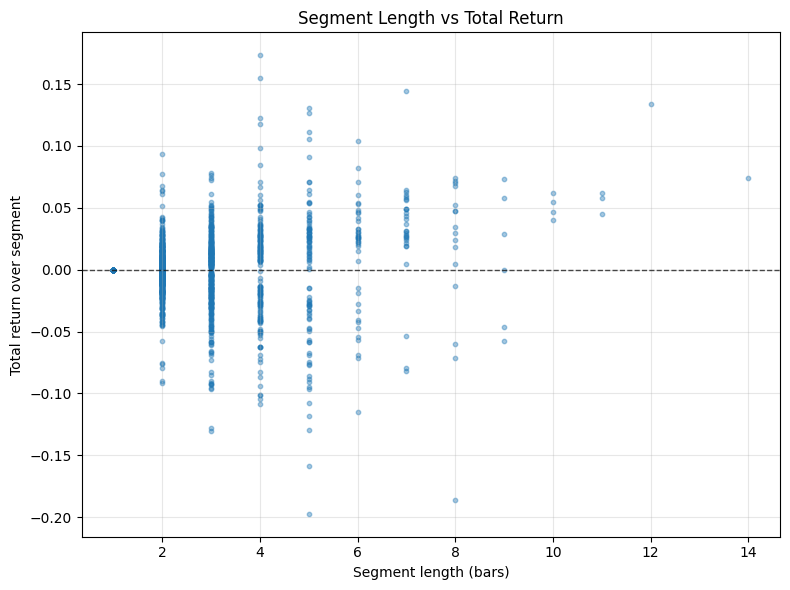

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    segments_df["segment_len"],
    segments_df["total_return"],
    s=10,
    alpha=0.4
)

plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.7)

plt.title("Segment Length vs Total Return")
plt.xlabel("Segment length (bars)")
plt.ylabel("Total return over segment")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# **IMPORT SENTIMENT**

In [66]:
from google.colab import files
import pandas as pd

# ---------- 1. Upload sentiment CSV ----------
print("Please upload final_sentiment_features_daily.csv")
uploaded = files.upload()

# Extract the filename (Colab stores it in the dict keys)
sent_path = list(uploaded.keys())[0]

# Load into DataFrame
sent_df = pd.read_csv(sent_path)

# Clean up column names (optional, as before)
sent_df.columns = [c.lower().strip() for c in sent_df.columns]

# Clean up column names
sent_df.columns = [c.lower().strip() for c in sent_df.columns]

if "date" not in sent_df.columns:
    raise ValueError("Sentiment CSV has no 'date' column.")

# Parse date (no tz, just calendar days)
sent_df["date"] = pd.to_datetime(sent_df["date"])

# Create a pure calendar-date key
sent_df["date_only"] = sent_df["date"].dt.date

# If there are multiple rows per date, keep the last one
sent_df = sent_df.sort_values("date").drop_duplicates("date_only", keep="last")

# These are all the sentiment-related features we want to attach
sent_feature_cols = [c for c in sent_df.columns if c not in ["date", "date_only"]]
print("Sentiment feature columns:", sent_feature_cols)

# We'll use only date_only + features for merging
sent_merge = sent_df[["date_only"] + sent_feature_cols]


# ---------- 2. Prepare df_daily_clean for merge without changing its index ----------
df_daily_with_sentiment = df_daily_clean.copy()

if not isinstance(df_daily_with_sentiment.index, pd.DatetimeIndex):
    raise TypeError("df_daily_clean index must be a DatetimeIndex.")

print("df_daily_clean index tz:", df_daily_with_sentiment.index.tz)

# Save original timestamp index so we can restore it after merge
df_daily_with_sentiment["timestamp"] = df_daily_with_sentiment.index

# Build the same calendar-date key from the index (this keeps the tz info untouched)
df_daily_with_sentiment["date_only"] = df_daily_with_sentiment["timestamp"].dt.date

# ---------- 3. Merge by calendar date (left join keeps ALL df_daily rows) ----------
df_daily_with_sentiment = df_daily_with_sentiment.merge(
    sent_merge,
    on="date_only",
    how="left"
)

# ---------- 4. Restore original index and tidy up ----------
df_daily_with_sentiment = df_daily_with_sentiment.set_index("timestamp")
df_daily_with_sentiment = df_daily_with_sentiment.sort_index()

# (Optional) drop date_only column if you don't need it
# df_daily_with_sentiment = df_daily_with_sentiment.drop(columns=["date_only"])

print("Final df_daily_with_sentiment shape:", df_daily_with_sentiment.shape)
print(df_daily_with_sentiment[sent_feature_cols].isna().sum().head())
df_daily_with_sentiment.columns

Please upload final_sentiment_features_daily.csv


Saving final_sentiment_features_daily.csv to final_sentiment_features_daily (1).csv
Sentiment feature columns: ['vixcls', 'fear greed', 'news sentiment', 'finbert_v1_bullish', 'finbert_v1_bearish', 'finbert_v1_neutral', 'finbert_v1_index', 'finbert_v1_scaled', 'finbert_v1_smooth7', 'finbert_v1_smooth30', 'finbert_v2_bullish', 'finbert_v2_bearish', 'finbert_v2_neutral', 'finbert_v2_index', 'finbert_v2_scaled', 'finbert_v2_smooth7', 'finbert_v2_smooth30']
df_daily_clean index tz: America/New_York
Final df_daily_with_sentiment shape: (6290, 63)
vixcls                   0
fear greed            2767
news sentiment           0
finbert_v1_bullish    2690
finbert_v1_bearish    2690
dtype: int64


Index(['price', 'High', 'Low', 'Open', 'Volume', 'return', 'log_return',
       'frequency', 'is_daily_anchor', 'is_day_close',
       'rolling_return_1@daily', 'rolling_return_5@daily',
       'rolling_return_21@daily', 'rolling_return_63@daily',
       'rolling_return_126@daily', 'rolling_return_252@daily',
       'rolling_volume_sum_1@daily', 'rolling_volume_roc_1@daily',
       'rolling_volume_sum_5@daily', 'rolling_volume_roc_5@daily',
       'rolling_volume_sum_21@daily', 'rolling_volume_roc_21@daily',
       'rolling_volume_sum_63@daily', 'rolling_volume_roc_63@daily',
       'rolling_volume_sum_126@daily', 'rolling_volume_roc_126@daily',
       'rolling_volume_sum_252@daily', 'rolling_volume_roc_252@daily',
       'volatility_stdev_1@daily', 'volatility_realized_1@daily',
       'volatility_stdev_5@daily', 'volatility_realized_5@daily',
       'volatility_stdev_21@daily', 'volatility_realized_21@daily',
       'volatility_stdev_63@daily', 'volatility_realized_63@daily',
       

# **LSTM**

In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

BASE_DF = df_daily_with_sentiment.copy().sort_index()
price_col = "price"
SPLIT_DATE = "2018-12-31"

tz = BASE_DF.index.tz
split_ts = pd.Timestamp(SPLIT_DATE)
if tz is not None:
    split_ts = split_ts.tz_localize(tz)

# --- utility: build dataset for a given horizon ---
def make_dataset(horizon):
    df = BASE_DF.copy()

    # target = horizon-day forward return
    df["future_price"] = df[price_col].shift(-horizon)
    df["target"] = df["future_price"] / df[price_col] - 1
    df = df.iloc[:-horizon]

    # drop rows with missing features / target
    df = df.dropna(subset=feature_cols + ["target"])

    # train/test split
    train_df = df[df.index <= split_ts].copy()
    test_df  = df[df.index >  split_ts].copy()

    return train_df, test_df

# --- utility: turn flat data into sequences for LSTM ---
def make_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for end in range(lookback, len(X)):
        X_seq.append(X[end-lookback:end])
        y_seq.append(y[end])
    return np.array(X_seq), np.array(y_seq)

# --- core experiment: train + evaluate one (lookback, horizon) pair ---
def run_lstm_experiment(lookback, horizon, verbose_model=False):
    print(f"\n=== LOOKBACK={lookback}, HORIZON={horizon} ===")

    train_df, test_df = make_dataset(horizon)

    # scale features
    scaler = StandardScaler()
    X_train_raw = train_df[feature_cols].values
    X_test_raw  = test_df[feature_cols].values

    scaler.fit(X_train_raw)
    X_train_scaled = scaler.transform(X_train_raw)
    X_test_scaled  = scaler.transform(X_test_raw)

    y_train_raw = train_df["target"].values
    y_test_raw  = test_df["target"].values

    # sequences
    X_train, y_train = make_sequences(X_train_scaled, y_train_raw, lookback)
    X_test,  y_test  = make_sequences(X_test_scaled,  y_test_raw,  lookback)

    print("Train seq:", X_train.shape, "Test seq:", X_test.shape)

    # model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback, len(feature_cols))),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1, activation="linear")
    ])

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    if verbose_model:
        model.summary()

    early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=60,
        batch_size=64,
        verbose=0,
        callbacks=[early_stop]
    )

    # evaluation
    test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)

    # predictions
    y_pred = model.predict(X_test, verbose=0).flatten()

    # correlation
    corr = np.corrcoef(y_pred, y_test)[0, 1]

    # quintile spread: how much better top 20% vs bottom 20%?
    df_eval = pd.DataFrame({
        "pred": y_pred,
        "true": y_test
    })
    df_eval["bin"] = pd.qcut(df_eval["pred"], q=5, labels=False)

    bin_means = df_eval.groupby("bin")["true"].mean()
    spread = bin_means.iloc[-1] - bin_means.iloc[0]

    print(f"Test MSE={test_mse:.6f}, MAE={test_mae:.4f}, Corr={corr:.4f}, Top–Bottom spread={spread:.4f}")
    print("Bin means:", bin_means.values)

    return {
        "lookback": lookback,
        "horizon": horizon,
        "mse": test_mse,
        "mae": test_mae,
        "corr": corr,
        "spread": spread
    }

# --- run grid of experiments ---
lookbacks = [40, 80, 120]
horizons = [10, 20, 30]

results = []
for L in lookbacks:
    for H in horizons:
        metrics = run_lstm_experiment(L, H)
        results.append(metrics)

results_df = pd.DataFrame(results)
print("\n=== Summary over all (lookback, horizon) pairs ===")
print(results_df.sort_values(by="corr", ascending=False))


=== LOOKBACK=40, HORIZON=5 ===
Train seq: (1862, 40, 57) Test seq: (1252, 40, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.004380, MAE=0.0516, Corr=0.0160, Top–Bottom spread=0.0018
Bin means: [0.00497816 0.00275139 0.00253521 0.00469173 0.0067854 ]

=== LOOKBACK=40, HORIZON=10 ===
Train seq: (1862, 40, 57) Test seq: (1252, 40, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.002892, MAE=0.0429, Corr=-0.1354, Top–Bottom spread=-0.0143
Bin means: [ 0.01335663  0.01560304  0.00482529  0.01003377 -0.00096911]

=== LOOKBACK=40, HORIZON=20 ===
Train seq: (1862, 40, 57) Test seq: (1252, 40, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.010209, MAE=0.0807, Corr=0.2633, Top–Bottom spread=0.0397
Bin means: [-0.00539505  0.00379148  0.00891765  0.04373821  0.03435379]

=== LOOKBACK=40, HORIZON=30 ===
Train seq: (1862, 40, 57) Test seq: (1252, 40, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.007457, MAE=0.0657, Corr=0.1887, Top–Bottom spread=0.0517
Bin means: [8.08133028e-05 1.50382721e-02 2.26328441e-02 3.60815186e-02
 5.18112614e-02]

=== LOOKBACK=80, HORIZON=5 ===
Train seq: (1822, 80, 57) Test seq: (1212, 80, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.007313, MAE=0.0713, Corr=-0.0040, Top–Bottom spread=0.0032
Bin means: [0.00418163 0.00536723 0.00283531 0.00080342 0.00738032]

=== LOOKBACK=80, HORIZON=10 ===
Train seq: (1822, 80, 57) Test seq: (1212, 80, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.004990, MAE=0.0556, Corr=-0.0635, Top–Bottom spread=-0.0058
Bin means: [0.00985943 0.00925309 0.01159389 0.00621663 0.00408108]

=== LOOKBACK=80, HORIZON=20 ===
Train seq: (1822, 80, 57) Test seq: (1212, 80, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.010034, MAE=0.0793, Corr=0.1599, Top–Bottom spread=0.0320
Bin means: [ 0.0151077  -0.00197344 -0.00400642  0.02807698  0.04706815]

=== LOOKBACK=80, HORIZON=30 ===
Train seq: (1822, 80, 57) Test seq: (1212, 80, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.015005, MAE=0.1034, Corr=0.0994, Top–Bottom spread=0.0200
Bin means: [0.03556432 0.0052399  0.02084799 0.01010532 0.05555634]

=== LOOKBACK=120, HORIZON=5 ===
Train seq: (1782, 120, 57) Test seq: (1172, 120, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.001430, MAE=0.0287, Corr=-0.0399, Top–Bottom spread=-0.0026
Bin means: [0.00702238 0.00598984 0.00334849 0.00074848 0.00440409]

=== LOOKBACK=120, HORIZON=10 ===
Train seq: (1782, 120, 57) Test seq: (1172, 120, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.002683, MAE=0.0401, Corr=0.0769, Top–Bottom spread=0.0111
Bin means: [-0.00248183  0.01345086  0.00827112  0.0141998   0.0086458 ]

=== LOOKBACK=120, HORIZON=20 ===
Train seq: (1782, 120, 57) Test seq: (1172, 120, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.004260, MAE=0.0525, Corr=0.2889, Top–Bottom spread=0.0600
Bin means: [-0.0096997   0.02050131  0.01066287  0.01215747  0.05032279]

=== LOOKBACK=120, HORIZON=30 ===
Train seq: (1782, 120, 57) Test seq: (1172, 120, 57)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Test MSE=0.007947, MAE=0.0718, Corr=0.0391, Top–Bottom spread=0.0022
Bin means: [0.01454256 0.02845173 0.00906437 0.05645753 0.01678861]

=== Summary over all (lookback, horizon) pairs ===
    lookback  horizon       mse       mae      corr    spread
10       120       20  0.004260  0.052483  0.288935  0.060022
2         40       20  0.010209  0.080665  0.263344  0.039749
3         40       30  0.007457  0.065740  0.188720  0.051730
6         80       20  0.010034  0.079333  0.159870  0.031960
7         80       30  0.015005  0.103356  0.099419  0.019992
9        120       10  0.002683  0.040102  0.076936  0.011128
11       120       30  0.007947  0.071778  0.039122  0.002246
0         40        5  0.004380  0.051557  0.015965  0.001807
4         80        5  0.007313  0.071272 -0.003997  0.003199
8        120        5  0.001430  0.028690 -0.039940 -0.002618
5         80       10  0.004990  0.055571 -0.063519 -0.005778
1         40       10  0.002892  0.042870 -0.135361 -0.014326


Number of feature columns: 57
Sample feature cols: ['price', 'High', 'Low', 'Open', 'Volume', 'return', 'log_return', 'is_daily_anchor', 'is_day_close', 'rolling_return_1@daily']
Data after NA drop: (3194, 64)
Train rows: 1902 Test rows: 1292
X_train: (1782, 120, 57) y_train: (1782,)
X_test: (1172, 120, 57) y_test: (1172,)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_60 (LSTM)                  │ (None, 120, 64)        │        31,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,737 (174.75 KB)

 Trainable params: 44,737 (174.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - loss: 0.0213 - mae: 0.1021 - val_loss: 0.0093 - val_mae: 0.0778
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - loss: 0.0038 - mae: 0.0478 - val_loss: 0.0065 - val_mae: 0.0642
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 0.0021 - mae: 0.0362 - val_loss: 0.0069 - val_mae: 0.0682
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.0017 - mae: 0.0324 - val_loss: 0.0068 - val_mae: 0.0675
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0060 - val_mae: 0.0638
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 0.0013 - mae: 0.0280 - val_loss: 0.0064 - val_mae: 0.0649
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - loss: 0.0012 - mae: 0.0265 - val_loss: 0.0069 - val_mae: 0.0683
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 9.9722e-04 - mae: 0.0245 - val_loss: 0.0062 - val_mae: 0.0643
Epoch 9/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step

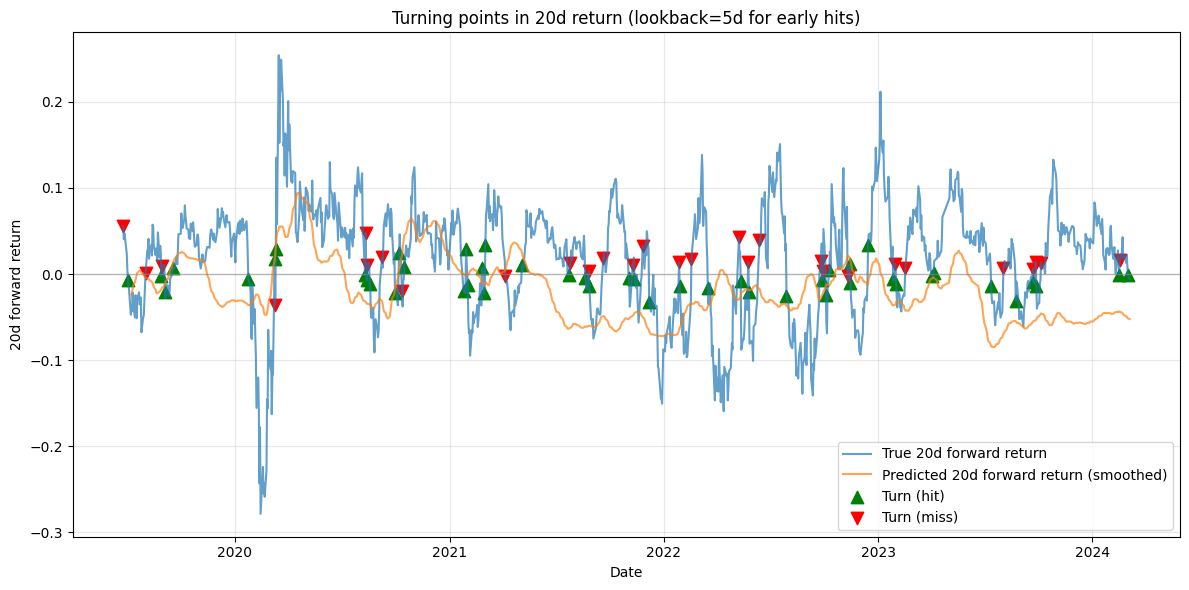

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# 1) Base data and feature set
# -----------------------------
BASE_DF = df_daily_with_sentiment.copy().sort_index()
price_col = "price"

# Columns we NEVER want as input features
exclude_cols = {
    "segment_id", "segment_len", "segment_dir", "regime",
    "date", "date_only",
    "future_price", "target",
    "next_10d_return",
    "lstm_pressure", "bin"
}

# Only numeric columns, excluding labels/meta
feature_cols = [
    c for c in BASE_DF.columns
    if c not in exclude_cols and is_numeric_dtype(BASE_DF[c])
]

print("Number of feature columns:", len(feature_cols))
print("Sample feature cols:", feature_cols[:10])

df = BASE_DF.copy()

# -----------------------------
# 2) Single-horizon target: 20d return
# -----------------------------
HORIZON = 20
df["true_fwd_return"] = df[price_col].shift(-HORIZON) / df[price_col] - 1

# Drop last HORIZON rows (no future info) and any NA rows
df = df.iloc[:-HORIZON]
df = df.dropna(subset=feature_cols + ["true_fwd_return"])
print("Data after NA drop:", df.shape)

# -----------------------------
# 3) Train / test split in time
# -----------------------------
SPLIT_DATE = "2018-12-31"
tz = df.index.tz
split_ts = pd.Timestamp(SPLIT_DATE)
if tz is not None:
    split_ts = split_ts.tz_localize(tz)

train_df = df[df.index <= split_ts].copy()
test_df  = df[df.index >  split_ts].copy()

print("Train rows:", len(train_df), "Test rows:", len(test_df))

# -----------------------------
# 4) Scale features
# -----------------------------
scaler = StandardScaler()
X_train_raw = train_df[feature_cols].values
X_test_raw  = test_df[feature_cols].values

scaler.fit(X_train_raw)
X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

y_train_raw = train_df["true_fwd_return"].values
y_test_raw  = test_df["true_fwd_return"].values

# -----------------------------
# 5) Make sequences for LSTM
# -----------------------------
LOOKBACK = 120  # final lookback window in days

def make_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for end in range(lookback, len(X)):
        X_seq.append(X[end-lookback:end])
        y_seq.append(y[end])
    return np.array(X_seq), np.array(y_seq)

X_train, y_train = make_sequences(X_train_scaled, y_train_raw, LOOKBACK)
X_test,  y_test  = make_sequences(X_test_scaled,  y_test_raw,  LOOKBACK)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:",  X_test.shape,  "y_test:",  y_test.shape)

n_features = X_train.shape[-1]

# -----------------------------
# 6) Build and train LSTM
# -----------------------------
model = Sequential([
    Input(shape=(LOOKBACK, n_features)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop]
)

test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\n=== 120/20 Test metrics ===")
print(f"Test MSE: {test_mse:.6f}, Test MAE: {test_mae:.6f}")

# -----------------------------
# 7) Build df_lstm_20 with aligned dates
# -----------------------------
# For test, the sequence ending at index i corresponds to test_df.index[i]
test_index_seq = test_df.index[LOOKBACK:]  # align with y_test & preds

y_pred = model.predict(X_test, verbose=0).flatten()

df_lstm_20 = pd.DataFrame({
    "price": test_df[price_col].iloc[LOOKBACK:].values,
    "true_fwd_return": y_test,
    "pred_fwd_return": y_pred
}, index=test_index_seq)

df_lstm_20 = df_lstm_20.dropna()
print("\nHead of df_lstm_20:")
print(df_lstm_20.head())

# -----------------------------
# 8) Directional accuracy & turning points
# -----------------------------
df = df_lstm_20.copy()

# Directional accuracy
df["true_sign"] = np.sign(df["true_fwd_return"])
df["pred_sign"] = np.sign(df["pred_fwd_return"])

mask_nonzero = df["true_sign"] != 0
dir_acc = (df.loc[mask_nonzero, "true_sign"] ==
           df.loc[mask_nonzero, "pred_sign"]).mean()
print(f"\nDirectional accuracy (sign of {HORIZON}d return): "
      f"{dir_acc:.2%} on {mask_nonzero.sum()} non-zero cases")

# Turning points
df["true_sign_prev"] = df["true_sign"].shift(1)
df["is_turn"] = (
    (df["true_sign"] != 0) &
    (df["true_sign_prev"] != 0) &
    (df["true_sign"] != df["true_sign_prev"])
)

turn_indices = np.where(df["is_turn"].values)[0]
print(f"Number of sign flips (turning points): {len(turn_indices)}")

LOOKBACK_TURNS = 5  # how many days early we give ourselves credit
hits = []
leads = []

for idx in turn_indices:
    new_sign = df["true_sign"].iloc[idx]
    start = max(0, idx - LOOKBACK_TURNS)
    window_pred = df["pred_sign"].iloc[start:idx+1].values

    hit_bool = (window_pred == new_sign).any()
    hits.append(int(hit_bool))

    if hit_bool:
        rel_positions = np.where(window_pred == new_sign)[0]
        first_rel = rel_positions[0]
        lead_days = idx - (start + first_rel)
        leads.append(lead_days)

turn_hit_rate = np.mean(hits) if hits else np.nan
avg_lead = np.mean(leads) if leads else np.nan

print(f"\nTurning-point hit rate (within {LOOKBACK_TURNS}d window): "
      f"{turn_hit_rate:.2%}")
if leads:
    print(f"Average lead time among hits: {avg_lead:.2f} days early")

# -----------------------------
# 9) Motion tracking (optional stat)
# -----------------------------
df["pred_fwd_smooth"] = df["pred_fwd_return"].rolling(10).mean()
df["d_true"] = df["true_fwd_return"].diff()
df["d_pred"] = df["pred_fwd_smooth"].diff()

motion_mask = df[["d_true", "d_pred"]].notna().all(axis=1)
motion_corr = np.corrcoef(df.loc[motion_mask, "d_true"],
                          df.loc[motion_mask, "d_pred"])[0, 1]
print(f"\nCorrelation of CHANGES (d_true vs d_pred): {motion_corr:.3f}")

# -----------------------------
# 10) Visualization for paper
# -----------------------------
# Mark which turns we hit in time
df["turn_hit"] = False
for idx, hit_flag in zip(turn_indices, hits):
    if hit_flag:
        df.iloc[idx, df.columns.get_loc("turn_hit")] = True

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["true_fwd_return"],
         label=f"True {HORIZON}d forward return", alpha=0.7)
plt.plot(df.index, df["pred_fwd_smooth"],
         label=f"Predicted {HORIZON}d forward return (smoothed)", alpha=0.7)

turn_dates = df.index[turn_indices]
turn_vals = df["true_fwd_return"].iloc[turn_indices]
hit_mask = df["turn_hit"].iloc[turn_indices].values.astype(bool)

plt.scatter(turn_dates[hit_mask], turn_vals[hit_mask],
            color="green", marker="^", s=80, label="Turn (hit)")
plt.scatter(turn_dates[~hit_mask], turn_vals[~hit_mask],
            color="red", marker="v", s=80, label="Turn (miss)")

plt.axhline(0, color="gray", linewidth=1, alpha=0.5)
plt.title(f"Turning points in {HORIZON}d return (lookback={LOOKBACK_TURNS}d for early hits)")
plt.ylabel(f"{HORIZON}d forward return")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Level corr: 0.226
Regression: true ≈ 0.0242 + 0.40 * pred


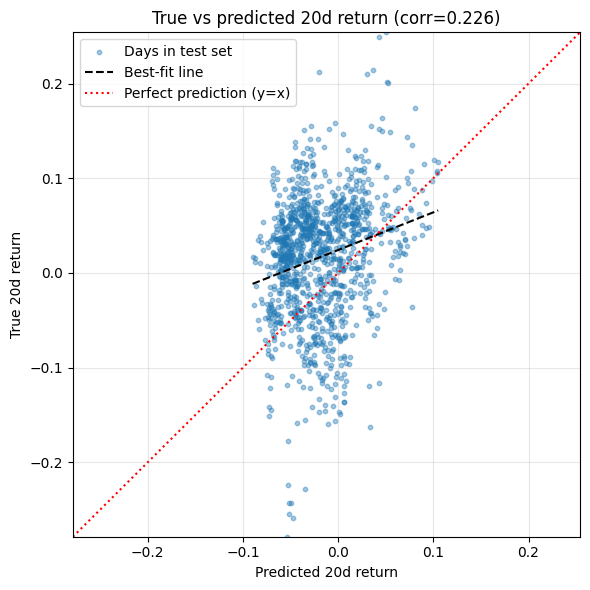

In [59]:
import numpy as np
import matplotlib.pyplot as plt

df = df_lstm_20.copy().dropna(subset=["true_fwd_return", "pred_fwd_return"])

y = df["true_fwd_return"].values
x = df["pred_fwd_return"].values

# basic stats
corr = np.corrcoef(x, y)[0, 1]
slope, intercept = np.polyfit(x, y, 1)   # y ≈ intercept + slope * x

print(f"Level corr: {corr:.3f}")
print(f"Regression: true ≈ {intercept:.4f} + {slope:.2f} * pred")

# scatter + regression line
plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.4, s=10, label="Days in test set")

xs = np.linspace(x.min(), x.max(), 100)
plt.plot(xs, intercept + slope*xs, "k--", label="Best-fit line")

lims = [min(x.min(), y.min()), max(x.max(), y.max())]
plt.plot(lims, lims, "r:", label="Perfect prediction (y=x)")
plt.xlim(lims); plt.ylim(lims)

plt.xlabel("Predicted 20d return")
plt.ylabel("True 20d return")
plt.title(f"True vs predicted 20d return (corr={corr:.3f})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


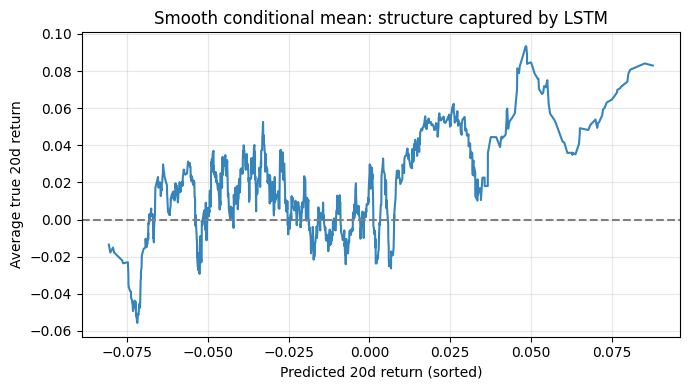

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df_lstm_20.copy().dropna()

# sort by predicted return
df_sorted = df.sort_values("pred_fwd_return")

# rolling mean of true return across sorted prediction
window = max(20, len(df) // 50)  # scale with sample size
df_sorted["smooth_true"] = df_sorted["true_fwd_return"].rolling(window, center=True).mean()

plt.figure(figsize=(7,4))
plt.plot(df_sorted["pred_fwd_return"], df_sorted["smooth_true"], alpha=0.9)
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Predicted 20d return (sorted)")
plt.ylabel("Average true 20d return")
plt.title("Smooth conditional mean: structure captured by LSTM")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [61]:
import pandas as pd
import numpy as np

df = df_lstm_20.copy().dropna(subset=["true_fwd_return", "pred_fwd_return"])

corr = np.corrcoef(df["pred_fwd_return"], df["true_fwd_return"])[0, 1]
mse = np.mean((df["true_fwd_return"] - df["pred_fwd_return"])**2)
mae = np.mean(np.abs(df["true_fwd_return"] - df["pred_fwd_return"]))

df["true_sign"] = np.sign(df["true_fwd_return"])
df["pred_sign"] = np.sign(df["pred_fwd_return"])
mask_nonzero = df["true_sign"] != 0
dir_acc = (df.loc[mask_nonzero, "true_sign"] ==
           df.loc[mask_nonzero, "pred_sign"]).mean()

metrics = pd.DataFrame({
    "metric": ["MSE", "MAE", "Correlation", "Directional accuracy"],
    "value": [mse, mae, corr, dir_acc]
})
print(metrics)


                 metric     value
0                   MSE  0.005743
1                   MAE  0.063168
2           Correlation  0.225914
3  Directional accuracy  0.499147


# AI Appendix

Portions of this project were developed with assistance from AI tools (ChatGPT). AI was used primarily for debugging help, code structuring ideas, generating boilerplate code patterns, and clarifying Python, pandas, and TensorFlow syntax. All core logic—including data engineering design, anchor-based feature calculations, trade-segmentation framework, model selection, and evaluation methodology—was designed, implemented, and validated by our team. Any AI-generated code snippets were reviewed, modified, and integrated manually to ensure correctness, interpretability, and alignment with our methodological goals. All conceptual decisions, modeling choices, and analysis were performed by the authors.